# Imports

In [1]:
import time
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

import pycocotools

In [2]:
# imports from local lib files
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

# Baseline

## File paths

In [3]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

## Basic data exploration

In [4]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann = json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [5]:
print('cis test set length:', len(cis_test_ann['images']))
print('cis val set length:', len(cis_val_ann['images']))
print('train set length:', len(train_ann['images']))
print('trans test set length:', len(trans_test_ann['images']))
print('trans val set length:', len(trans_val_ann['images']))

cis test set length: 15827
cis val set length: 3484
train set length: 13553
trans test set length: 23275
trans val set length: 1725


In [6]:
# i = 0

# boxes = [trans_val_ann['annotations'][j]['bbox'] for j in range(len(trans_val_ann['annotations'])) 
#          if trans_val_ann['annotations'][j]['image_id']==trans_val_ann['images'][i]['id'] 
#          and 'bbox' in trans_val_ann['annotations'][j].keys()]

# img_path = os.path.join('eccv_18_all_images_sm', trans_val_ann['images'][i]['file_name']) # to change

# image = read_image(img_path)

# fig, ax = plt.subplots()
# ax.imshow(image[0].squeeze(),cmap="gray")

# scale_x = image.shape[2] / trans_val_ann['images'][i]['width'] 
# scale_y = image.shape[1] / trans_val_ann['images'][i]['height']

# boxes = torch.as_tensor(boxes)

# for i in range(boxes.shape[0]):
#     boxes[i][0] = torch.round(boxes[i][0] * scale_x)
#     boxes[i][1] = torch.round(boxes[i][1] * scale_y)
#     boxes[i][2] = torch.round(boxes[i][2] * scale_x)
#     boxes[i][3] = torch.round(boxes[i][3] * scale_y)

#     boxes[i][2] = boxes[i][0] + boxes[i][2]
#     boxes[i][3] = boxes[i][1] + boxes[i][3]

# target = {}
# target["boxes"] = boxes

# rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], 
#                          boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
# ax.add_patch(rect)

## Utils

In [7]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

In [8]:
# Returns a list with the idx of images with at least one bounding box (img_wbbox) and a 
# list with the number of bbox for each valid image (num_bbox)
def get_img_with_bbox(file_path):
  
    file = json.load(open(file_path))
    img_wbbox = []
    num_bbox = []

    for i in range(len(file['images'])):
        bboxes = [file['annotations'][j]['bbox'] 
                  for j in range(len(file['annotations'])) 
                  if file['annotations'][j]['image_id']==file['images'][i]['id'] 
                  and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform = None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.valid_img = valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx = self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv = torchvision.transforms.ToTensor()
        # if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image = conv(image)

        boxes = [self.label_file['annotations'][j]['bbox'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
        label = [self.label_file['annotations'][j]['category_id'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
        scale_y = image.shape[1] / self.label_file['images'][idx]['height']

        boxes = torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0] = torch.round(boxes[i][0] * scale_x)
            boxes[i][1] = torch.round(boxes[i][1] * scale_y)
            boxes[i][2] = torch.round(boxes[i][2] * scale_x)
            boxes[i][3] = torch.round(boxes[i][3] * scale_y)

            boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3] = boxes[i][1] + boxes[i][3]

        label = torch.as_tensor(label)
        label = torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)

        return image, target

## Pre-trained models
Inspred from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

### Model with only the last layer to train

In [ ]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Model with deeper layers to train

In [10]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    for param in model.roi_heads.parameters():
        param.requires_grad = True

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper, construct the scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

### Create the dataloaders
To load the data of the dataset efficiently for the model

In [ ]:
# def create_dataloader(ann_path, batch_size, shuffle=True, transform):
#     valid_img,_ = get_img_with_bbox(ann_path)
#     data = CustomImageDataset(train_ann_path, img_folder, train_valid_img)

In [12]:
# Without data augmentation (transformations)
train_valid_img,_ = get_img_with_bbox(train_ann_path)
train_data = CustomImageDataset(train_ann_path, img_folder, train_valid_img)
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [ ]:
# With horizontal flip transformation applied
train_valid_img,_ = get_img_with_bbox(train_ann_path)
train_data = CustomImageDataset(label_path=train_ann_path, img_dir=img_folder, valid_img=train_valid_img, 
                                transform=data_transform['train'])
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [13]:
trans_val_valid_img,_ = get_img_with_bbox(trans_val_ann_path)
trans_valid_data = CustomImageDataset(trans_val_ann_path, img_folder, trans_val_valid_img)
trans_valid_dataloader = DataLoader(trans_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [14]:
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)
cis_valid_data = CustomImageDataset(cis_val_ann_path, img_folder, cis_val_valid_img)
cis_valid_dataloader = DataLoader(cis_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [15]:
cis_test_valid_img,_ = get_img_with_bbox(cis_test_ann_path)
cis_test_data = CustomImageDataset(cis_test_ann_path,img_folder, cis_test_valid_img)
cis_test_dataloader = DataLoader(cis_test_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [16]:
trans_test_valid_img,_ = get_img_with_bbox(trans_test_ann_path)
trans_test_data = CustomImageDataset(trans_test_ann_path,img_folder, trans_test_valid_img)
trans_test_dataloader = DataLoader(trans_test_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

## Loading/Importing a model
#### Need to initiate the model, the optimizer and de scheduler before loading

In [ ]:
# NEED TO INITIATE THE MODEL, THE OPTIMIZER AND THE SCHEDULER BEFOREHAND (if )
# load the model, the optimizer and the scheduler
model.load_state_dict(torch.load('saved_models/15_method_3_model.pt'))
optimizer.load_state_dict(torch.load('saved_models/15_method_3_optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_models/15_method_3_scheduler.pt'))
model.eval()

## Logs utils

#### Train logs utils

In [17]:
import time

In [18]:
# Converts the smoothed values to a dictionnary of each values
def smoothed_value_to_str(smoothed_value):
    d_values = {}
    d_values['median'] = smoothed_value.median
    d_values['avg'] = smoothed_value.avg
    d_values['global_avg'] = smoothed_value.global_avg
    d_values['max'] = smoothed_value.max
    d_values['value'] = smoothed_value.value
    return d_values


# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst


# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

In [19]:
# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst

In [20]:
# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

#### Valid logs utils

In [21]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    try:
        for i in range(len(logs)):
            logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
        return logs_better
    except:
        print(logs[0])
        logs_better = logs
        return logs_better

In [22]:
# Converts the valid logs from list of dictionnaries to string
def valid_logs_to_lst(valid_logs):
    logs = merge_dict(valid_logs)
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].cpu().numpy().tolist()
        lst.append(d)
    return lst

In [23]:
# Puts the cis validation logs into a json file with time dependent file name
def cis_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_cis_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

In [24]:
# Puts the trans validation logs into a json file with time dependent file name
def trans_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_trans_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

## Training the model

In [25]:
# PARAMETERS TO TUNE BEFORE TRAINING
num_epochs = 25

In [26]:
# CHECK DEVICE BEFORE TRAINING
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

In [27]:
# Defining the train function
def train(dataloader, num_epochs, save_logs=True, save_model=True, print_freq=100):
    
    model.train()
    
    all_train_logs = []
    all_cis_valid_logs = []
    all_trans_valid_logs = []

    for epoch in range(num_epochs):
        
        # train for one epoch, printing every 100 images
        train_logs = train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq)
        all_train_logs.append(train_logs)
        
        # update the learning rate
        lr_scheduler.step()
        
        # evaluate on the validation dataset after training one epoch
        for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                trans_loss_dict = model(images, targets)
                trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
                all_trans_valid_logs.append(trans_loss_dict)


        for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                cis_loss_dict = model(images, targets)
                cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
                all_cis_valid_logs.append(cis_loss_dict)
    
    filetime = time.strftime("%Y%m%d_%H%M%S")
    
    if save_logs:
        
        # save the train, cis valid and trans valid logs
        train_logs_to_json(all_train_logs, filetime)
        cis_valid_logs_to_json(all_cis_valid_logs, filetime)
        trans_valid_logs_to_json(all_trans_valid_logs, filetime)
        
    if save_model:
        
        # save the model, the optimizer and the scheduler
        torch.save(model.state_dict(), 'saved_models/' + filetime + '_model.pt')
        torch.save(optimizer.state_dict(), 'saved_models/' + filetime + '_optimizer.pt')
        torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + '_scheduler.pt')
    
    return all_train_logs, all_trans_valid_logs, all_cis_valid_logs


#### This next cell starts the training of the model

In [28]:
# TRAIN
all_train_logs, all_trans_valid_logs, all_cis_valid_logs = train(dataloader=train_dataloader, num_epochs=num_epochs)

C:\Users\kevin\miniconda3\envs\animals\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [    0/12099]  eta: 8:12:07  lr: 0.000001  loss: 1.0625 (1.0625)  loss_classifier: 0.8954 (0.8954)  loss_box_reg: 0.1622 (0.1622)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0047 (0.0047)  time: 2.4405  data: 0.0340  max mem: 524
Epoch: [0]  [  100/12099]  eta: 0:29:23  lr: 0.000031  loss: 0.2921 (0.6506)  loss_classifier: 0.1569 (0.4859)  loss_box_reg: 0.1174 (0.1336)  loss_objectness: 0.0034 (0.0236)  loss_rpn_box_reg: 0.0031 (0.0075)  time: 0.1230  data: 0.0319  max mem: 630
Epoch: [0]  [  200/12099]  eta: 0:26:56  lr: 0.000061  loss: 0.2396 (0.4601)  loss_classifier: 0.0993 (0.3001)  loss_box_reg: 0.1080 (0.1261)  loss_objectness: 0.0074 (0.0258)  loss_rpn_box_reg: 0.0036 (0.0081)  time: 0.1232  data: 0.0325  max mem: 630
Epoch: [0]  [  300/12099]  eta: 0:26:02  lr: 0.000091  loss: 0.2414 (0.3917)  loss_classifier: 0.0865 (0.2321)  loss_box_reg: 0.1272 (0.1234)  loss_objectness: 0.0062 (0.0285)  loss_rpn_box_reg: 0.0025 (0.0076)  time: 0.1251  data: 0.0340  m

Epoch: [0]  [ 3300/12099]  eta: 0:19:20  lr: 0.000300  loss: 0.1385 (0.1857)  loss_classifier: 0.0422 (0.0694)  loss_box_reg: 0.0487 (0.0750)  loss_objectness: 0.0188 (0.0332)  loss_rpn_box_reg: 0.0042 (0.0080)  time: 0.1421  data: 0.0395  max mem: 630
Epoch: [0]  [ 3400/12099]  eta: 0:19:08  lr: 0.000300  loss: 0.1153 (0.1850)  loss_classifier: 0.0310 (0.0687)  loss_box_reg: 0.0405 (0.0746)  loss_objectness: 0.0052 (0.0336)  loss_rpn_box_reg: 0.0017 (0.0081)  time: 0.1355  data: 0.0385  max mem: 630
Epoch: [0]  [ 3500/12099]  eta: 0:18:54  lr: 0.000300  loss: 0.1023 (0.1838)  loss_classifier: 0.0318 (0.0680)  loss_box_reg: 0.0614 (0.0742)  loss_objectness: 0.0034 (0.0336)  loss_rpn_box_reg: 0.0040 (0.0080)  time: 0.1250  data: 0.0324  max mem: 630
Epoch: [0]  [ 3600/12099]  eta: 0:18:41  lr: 0.000300  loss: 0.1335 (0.1830)  loss_classifier: 0.0449 (0.0674)  loss_box_reg: 0.0660 (0.0738)  loss_objectness: 0.0196 (0.0338)  loss_rpn_box_reg: 0.0029 (0.0080)  time: 0.1253  data: 0.0330  m

Epoch: [0]  [ 6600/12099]  eta: 0:11:56  lr: 0.000300  loss: 0.1182 (0.1626)  loss_classifier: 0.0330 (0.0551)  loss_box_reg: 0.0567 (0.0656)  loss_objectness: 0.0096 (0.0339)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1311  data: 0.0366  max mem: 630
Epoch: [0]  [ 6700/12099]  eta: 0:11:43  lr: 0.000300  loss: 0.1059 (0.1624)  loss_classifier: 0.0329 (0.0549)  loss_box_reg: 0.0573 (0.0655)  loss_objectness: 0.0074 (0.0339)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1282  data: 0.0356  max mem: 630
Epoch: [0]  [ 6800/12099]  eta: 0:11:30  lr: 0.000300  loss: 0.1059 (0.1620)  loss_classifier: 0.0274 (0.0547)  loss_box_reg: 0.0433 (0.0653)  loss_objectness: 0.0034 (0.0339)  loss_rpn_box_reg: 0.0018 (0.0080)  time: 0.1220  data: 0.0331  max mem: 630
Epoch: [0]  [ 6900/12099]  eta: 0:11:16  lr: 0.000300  loss: 0.1145 (0.1614)  loss_classifier: 0.0253 (0.0545)  loss_box_reg: 0.0504 (0.0652)  loss_objectness: 0.0056 (0.0338)  loss_rpn_box_reg: 0.0024 (0.0080)  time: 0.1203  data: 0.0323  m

Epoch: [0]  [ 9900/12099]  eta: 0:04:43  lr: 0.000300  loss: 0.1030 (0.1525)  loss_classifier: 0.0295 (0.0494)  loss_box_reg: 0.0509 (0.0619)  loss_objectness: 0.0025 (0.0334)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1192  data: 0.0318  max mem: 630
Epoch: [0]  [10000/12099]  eta: 0:04:30  lr: 0.000300  loss: 0.1265 (0.1522)  loss_classifier: 0.0249 (0.0492)  loss_box_reg: 0.0354 (0.0618)  loss_objectness: 0.0193 (0.0334)  loss_rpn_box_reg: 0.0043 (0.0078)  time: 0.1195  data: 0.0318  max mem: 630
Epoch: [0]  [10100/12099]  eta: 0:04:17  lr: 0.000300  loss: 0.0966 (0.1519)  loss_classifier: 0.0266 (0.0491)  loss_box_reg: 0.0544 (0.0617)  loss_objectness: 0.0042 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1287  data: 0.0359  max mem: 630
Epoch: [0]  [10200/12099]  eta: 0:04:04  lr: 0.000300  loss: 0.0934 (0.1516)  loss_classifier: 0.0242 (0.0490)  loss_box_reg: 0.0395 (0.0616)  loss_objectness: 0.0080 (0.0332)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1261  data: 0.0340  m

Epoch: [1]  [ 1000/12099]  eta: 0:22:06  lr: 0.000300  loss: 0.1371 (0.1280)  loss_classifier: 0.0380 (0.0351)  loss_box_reg: 0.0474 (0.0507)  loss_objectness: 0.0169 (0.0337)  loss_rpn_box_reg: 0.0025 (0.0086)  time: 0.1198  data: 0.0314  max mem: 3858
Epoch: [1]  [ 1100/12099]  eta: 0:21:54  lr: 0.000300  loss: 0.0894 (0.1285)  loss_classifier: 0.0225 (0.0352)  loss_box_reg: 0.0349 (0.0510)  loss_objectness: 0.0031 (0.0338)  loss_rpn_box_reg: 0.0024 (0.0085)  time: 0.1214  data: 0.0318  max mem: 3858
Epoch: [1]  [ 1200/12099]  eta: 0:21:43  lr: 0.000300  loss: 0.1010 (0.1277)  loss_classifier: 0.0241 (0.0351)  loss_box_reg: 0.0413 (0.0510)  loss_objectness: 0.0083 (0.0331)  loss_rpn_box_reg: 0.0039 (0.0085)  time: 0.1193  data: 0.0315  max mem: 3858
Epoch: [1]  [ 1300/12099]  eta: 0:21:31  lr: 0.000300  loss: 0.0988 (0.1273)  loss_classifier: 0.0228 (0.0350)  loss_box_reg: 0.0501 (0.0512)  loss_objectness: 0.0118 (0.0327)  loss_rpn_box_reg: 0.0023 (0.0083)  time: 0.1198  data: 0.0319

Epoch: [1]  [ 4300/12099]  eta: 0:15:33  lr: 0.000300  loss: 0.1228 (0.1283)  loss_classifier: 0.0276 (0.0349)  loss_box_reg: 0.0496 (0.0517)  loss_objectness: 0.0137 (0.0338)  loss_rpn_box_reg: 0.0047 (0.0079)  time: 0.1191  data: 0.0316  max mem: 3858
Epoch: [1]  [ 4400/12099]  eta: 0:15:21  lr: 0.000300  loss: 0.1006 (0.1287)  loss_classifier: 0.0220 (0.0349)  loss_box_reg: 0.0402 (0.0517)  loss_objectness: 0.0103 (0.0341)  loss_rpn_box_reg: 0.0039 (0.0080)  time: 0.1200  data: 0.0325  max mem: 3858
Epoch: [1]  [ 4500/12099]  eta: 0:15:09  lr: 0.000300  loss: 0.0937 (0.1287)  loss_classifier: 0.0214 (0.0348)  loss_box_reg: 0.0449 (0.0518)  loss_objectness: 0.0040 (0.0341)  loss_rpn_box_reg: 0.0023 (0.0080)  time: 0.1209  data: 0.0323  max mem: 3858
Epoch: [1]  [ 4600/12099]  eta: 0:14:57  lr: 0.000300  loss: 0.1107 (0.1285)  loss_classifier: 0.0243 (0.0348)  loss_box_reg: 0.0551 (0.0517)  loss_objectness: 0.0150 (0.0340)  loss_rpn_box_reg: 0.0024 (0.0080)  time: 0.1184  data: 0.0311

Epoch: [1]  [ 7600/12099]  eta: 0:08:58  lr: 0.000300  loss: 0.0911 (0.1277)  loss_classifier: 0.0269 (0.0345)  loss_box_reg: 0.0442 (0.0520)  loss_objectness: 0.0045 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1194  data: 0.0319  max mem: 3858
Epoch: [1]  [ 7700/12099]  eta: 0:08:46  lr: 0.000300  loss: 0.1283 (0.1277)  loss_classifier: 0.0307 (0.0345)  loss_box_reg: 0.0493 (0.0519)  loss_objectness: 0.0122 (0.0334)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1188  data: 0.0308  max mem: 3858
Epoch: [1]  [ 7800/12099]  eta: 0:08:34  lr: 0.000300  loss: 0.1196 (0.1275)  loss_classifier: 0.0265 (0.0344)  loss_box_reg: 0.0580 (0.0519)  loss_objectness: 0.0161 (0.0334)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1203  data: 0.0326  max mem: 3858
Epoch: [1]  [ 7900/12099]  eta: 0:08:22  lr: 0.000300  loss: 0.1151 (0.1275)  loss_classifier: 0.0273 (0.0344)  loss_box_reg: 0.0420 (0.0519)  loss_objectness: 0.0197 (0.0333)  loss_rpn_box_reg: 0.0042 (0.0078)  time: 0.1185  data: 0.0312

Epoch: [1]  [10900/12099]  eta: 0:02:23  lr: 0.000300  loss: 0.1004 (0.1268)  loss_classifier: 0.0239 (0.0339)  loss_box_reg: 0.0478 (0.0515)  loss_objectness: 0.0031 (0.0335)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1223  data: 0.0341  max mem: 3858
Epoch: [1]  [11000/12099]  eta: 0:02:11  lr: 0.000300  loss: 0.1341 (0.1267)  loss_classifier: 0.0324 (0.0339)  loss_box_reg: 0.0542 (0.0515)  loss_objectness: 0.0082 (0.0335)  loss_rpn_box_reg: 0.0042 (0.0078)  time: 0.1196  data: 0.0319  max mem: 3858
Epoch: [1]  [11100/12099]  eta: 0:01:59  lr: 0.000300  loss: 0.1008 (0.1267)  loss_classifier: 0.0325 (0.0338)  loss_box_reg: 0.0495 (0.0515)  loss_objectness: 0.0066 (0.0335)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1206  data: 0.0330  max mem: 3858
Epoch: [1]  [11200/12099]  eta: 0:01:47  lr: 0.000300  loss: 0.1196 (0.1267)  loss_classifier: 0.0328 (0.0339)  loss_box_reg: 0.0507 (0.0515)  loss_objectness: 0.0165 (0.0335)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1202  data: 0.0322

Epoch: [2]  [ 2000/12099]  eta: 0:20:08  lr: 0.000300  loss: 0.0743 (0.1223)  loss_classifier: 0.0195 (0.0317)  loss_box_reg: 0.0401 (0.0489)  loss_objectness: 0.0023 (0.0338)  loss_rpn_box_reg: 0.0021 (0.0080)  time: 0.1203  data: 0.0330  max mem: 3859
Epoch: [2]  [ 2100/12099]  eta: 0:19:56  lr: 0.000300  loss: 0.0899 (0.1224)  loss_classifier: 0.0177 (0.0317)  loss_box_reg: 0.0400 (0.0488)  loss_objectness: 0.0060 (0.0339)  loss_rpn_box_reg: 0.0029 (0.0080)  time: 0.1178  data: 0.0308  max mem: 3859
Epoch: [2]  [ 2200/12099]  eta: 0:19:44  lr: 0.000300  loss: 0.1086 (0.1222)  loss_classifier: 0.0205 (0.0316)  loss_box_reg: 0.0423 (0.0489)  loss_objectness: 0.0051 (0.0338)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1189  data: 0.0315  max mem: 3859
Epoch: [2]  [ 2300/12099]  eta: 0:19:32  lr: 0.000300  loss: 0.1036 (0.1225)  loss_classifier: 0.0279 (0.0317)  loss_box_reg: 0.0598 (0.0491)  loss_objectness: 0.0104 (0.0340)  loss_rpn_box_reg: 0.0014 (0.0078)  time: 0.1199  data: 0.0323

Epoch: [2]  [ 5300/12099]  eta: 0:13:34  lr: 0.000300  loss: 0.0742 (0.1218)  loss_classifier: 0.0221 (0.0312)  loss_box_reg: 0.0461 (0.0496)  loss_objectness: 0.0036 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0077)  time: 0.1199  data: 0.0329  max mem: 3859
Epoch: [2]  [ 5400/12099]  eta: 0:13:22  lr: 0.000300  loss: 0.0980 (0.1218)  loss_classifier: 0.0241 (0.0312)  loss_box_reg: 0.0477 (0.0496)  loss_objectness: 0.0148 (0.0333)  loss_rpn_box_reg: 0.0034 (0.0077)  time: 0.1223  data: 0.0336  max mem: 3859
Epoch: [2]  [ 5500/12099]  eta: 0:13:12  lr: 0.000300  loss: 0.0817 (0.1215)  loss_classifier: 0.0208 (0.0311)  loss_box_reg: 0.0455 (0.0496)  loss_objectness: 0.0022 (0.0331)  loss_rpn_box_reg: 0.0021 (0.0077)  time: 0.1274  data: 0.0362  max mem: 3859
Epoch: [2]  [ 5600/12099]  eta: 0:13:01  lr: 0.000300  loss: 0.1014 (0.1217)  loss_classifier: 0.0219 (0.0311)  loss_box_reg: 0.0397 (0.0496)  loss_objectness: 0.0152 (0.0332)  loss_rpn_box_reg: 0.0033 (0.0077)  time: 0.1273  data: 0.0361

Epoch: [2]  [ 8600/12099]  eta: 0:07:02  lr: 0.000300  loss: 0.0901 (0.1223)  loss_classifier: 0.0223 (0.0313)  loss_box_reg: 0.0420 (0.0497)  loss_objectness: 0.0027 (0.0335)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1203  data: 0.0323  max mem: 3859
Epoch: [2]  [ 8700/12099]  eta: 0:06:50  lr: 0.000300  loss: 0.1020 (0.1224)  loss_classifier: 0.0286 (0.0313)  loss_box_reg: 0.0448 (0.0498)  loss_objectness: 0.0166 (0.0335)  loss_rpn_box_reg: 0.0037 (0.0079)  time: 0.1199  data: 0.0316  max mem: 3859
Epoch: [2]  [ 8800/12099]  eta: 0:06:37  lr: 0.000300  loss: 0.0800 (0.1224)  loss_classifier: 0.0199 (0.0313)  loss_box_reg: 0.0367 (0.0497)  loss_objectness: 0.0014 (0.0335)  loss_rpn_box_reg: 0.0016 (0.0079)  time: 0.1197  data: 0.0316  max mem: 3859
Epoch: [2]  [ 8900/12099]  eta: 0:06:25  lr: 0.000300  loss: 0.1035 (0.1223)  loss_classifier: 0.0254 (0.0313)  loss_box_reg: 0.0523 (0.0497)  loss_objectness: 0.0064 (0.0335)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1200  data: 0.0319

Epoch: [2]  [11900/12099]  eta: 0:00:24  lr: 0.000300  loss: 0.1116 (0.1218)  loss_classifier: 0.0259 (0.0311)  loss_box_reg: 0.0367 (0.0496)  loss_objectness: 0.0150 (0.0333)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1189  data: 0.0312  max mem: 3859
Epoch: [2]  [12000/12099]  eta: 0:00:12  lr: 0.000300  loss: 0.1289 (0.1218)  loss_classifier: 0.0314 (0.0311)  loss_box_reg: 0.0478 (0.0496)  loss_objectness: 0.0260 (0.0333)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1178  data: 0.0308  max mem: 3859
Epoch: [2]  [12098/12099]  eta: 0:00:00  lr: 0.000300  loss: 0.0705 (0.1218)  loss_classifier: 0.0236 (0.0311)  loss_box_reg: 0.0408 (0.0495)  loss_objectness: 0.0046 (0.0334)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1190  data: 0.0321  max mem: 3859
Epoch: [2] Total time: 0:24:30 (0.1215 s / it)
Epoch: [3]  [    0/12099]  eta: 0:23:05  lr: 0.000300  loss: 0.0870 (0.0870)  loss_classifier: 0.0229 (0.0229)  loss_box_reg: 0.0613 (0.0613)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_r

Epoch: [3]  [ 3000/12099]  eta: 0:18:11  lr: 0.000300  loss: 0.1195 (0.1185)  loss_classifier: 0.0356 (0.0303)  loss_box_reg: 0.0328 (0.0488)  loss_objectness: 0.0095 (0.0318)  loss_rpn_box_reg: 0.0036 (0.0077)  time: 0.1185  data: 0.0312  max mem: 3859
Epoch: [3]  [ 3100/12099]  eta: 0:17:59  lr: 0.000300  loss: 0.1165 (0.1188)  loss_classifier: 0.0316 (0.0302)  loss_box_reg: 0.0408 (0.0486)  loss_objectness: 0.0041 (0.0321)  loss_rpn_box_reg: 0.0069 (0.0078)  time: 0.1200  data: 0.0325  max mem: 3859
Epoch: [3]  [ 3200/12099]  eta: 0:17:47  lr: 0.000300  loss: 0.0839 (0.1190)  loss_classifier: 0.0237 (0.0302)  loss_box_reg: 0.0417 (0.0487)  loss_objectness: 0.0120 (0.0324)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1187  data: 0.0313  max mem: 3859
Epoch: [3]  [ 3300/12099]  eta: 0:17:35  lr: 0.000300  loss: 0.1133 (0.1190)  loss_classifier: 0.0216 (0.0301)  loss_box_reg: 0.0315 (0.0487)  loss_objectness: 0.0183 (0.0324)  loss_rpn_box_reg: 0.0038 (0.0077)  time: 0.1192  data: 0.0323

Epoch: [3]  [ 6300/12099]  eta: 0:11:42  lr: 0.000300  loss: 0.0924 (0.1195)  loss_classifier: 0.0215 (0.0299)  loss_box_reg: 0.0471 (0.0486)  loss_objectness: 0.0087 (0.0331)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 0.1205  data: 0.0317  max mem: 3859
Epoch: [3]  [ 6400/12099]  eta: 0:11:30  lr: 0.000300  loss: 0.1125 (0.1196)  loss_classifier: 0.0183 (0.0299)  loss_box_reg: 0.0417 (0.0487)  loss_objectness: 0.0016 (0.0331)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1195  data: 0.0324  max mem: 3859
Epoch: [3]  [ 6500/12099]  eta: 0:11:18  lr: 0.000300  loss: 0.1007 (0.1195)  loss_classifier: 0.0301 (0.0299)  loss_box_reg: 0.0490 (0.0487)  loss_objectness: 0.0206 (0.0331)  loss_rpn_box_reg: 0.0037 (0.0078)  time: 0.1194  data: 0.0321  max mem: 3859
Epoch: [3]  [ 6600/12099]  eta: 0:11:05  lr: 0.000300  loss: 0.1037 (0.1194)  loss_classifier: 0.0289 (0.0298)  loss_box_reg: 0.0438 (0.0486)  loss_objectness: 0.0076 (0.0331)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1190  data: 0.0317

Epoch: [3]  [ 9600/12099]  eta: 0:05:02  lr: 0.000300  loss: 0.0966 (0.1194)  loss_classifier: 0.0215 (0.0296)  loss_box_reg: 0.0364 (0.0486)  loss_objectness: 0.0072 (0.0333)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1196  data: 0.0323  max mem: 3859
Epoch: [3]  [ 9700/12099]  eta: 0:04:50  lr: 0.000300  loss: 0.0913 (0.1193)  loss_classifier: 0.0177 (0.0296)  loss_box_reg: 0.0268 (0.0485)  loss_objectness: 0.0035 (0.0333)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1193  data: 0.0316  max mem: 3859
Epoch: [3]  [ 9800/12099]  eta: 0:04:38  lr: 0.000300  loss: 0.1074 (0.1192)  loss_classifier: 0.0243 (0.0296)  loss_box_reg: 0.0408 (0.0485)  loss_objectness: 0.0234 (0.0333)  loss_rpn_box_reg: 0.0037 (0.0079)  time: 0.1326  data: 0.0377  max mem: 3859
Epoch: [3]  [ 9900/12099]  eta: 0:04:26  lr: 0.000300  loss: 0.1222 (0.1192)  loss_classifier: 0.0253 (0.0295)  loss_box_reg: 0.0411 (0.0485)  loss_objectness: 0.0053 (0.0333)  loss_rpn_box_reg: 0.0039 (0.0079)  time: 0.1218  data: 0.0321

Epoch: [4]  [  700/12099]  eta: 0:22:30  lr: 0.000300  loss: 0.0904 (0.1193)  loss_classifier: 0.0209 (0.0291)  loss_box_reg: 0.0468 (0.0496)  loss_objectness: 0.0040 (0.0329)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1196  data: 0.0312  max mem: 3859
Epoch: [4]  [  800/12099]  eta: 0:22:17  lr: 0.000300  loss: 0.0808 (0.1197)  loss_classifier: 0.0205 (0.0290)  loss_box_reg: 0.0407 (0.0492)  loss_objectness: 0.0039 (0.0335)  loss_rpn_box_reg: 0.0029 (0.0080)  time: 0.1186  data: 0.0315  max mem: 3859
Epoch: [4]  [  900/12099]  eta: 0:22:05  lr: 0.000300  loss: 0.0868 (0.1192)  loss_classifier: 0.0222 (0.0290)  loss_box_reg: 0.0403 (0.0493)  loss_objectness: 0.0124 (0.0331)  loss_rpn_box_reg: 0.0017 (0.0077)  time: 0.1184  data: 0.0307  max mem: 3859
Epoch: [4]  [ 1000/12099]  eta: 0:21:56  lr: 0.000300  loss: 0.0544 (0.1179)  loss_classifier: 0.0149 (0.0288)  loss_box_reg: 0.0292 (0.0490)  loss_objectness: 0.0068 (0.0323)  loss_rpn_box_reg: 0.0012 (0.0078)  time: 0.1199  data: 0.0318

Epoch: [4]  [ 4000/12099]  eta: 0:16:01  lr: 0.000300  loss: 0.0955 (0.1174)  loss_classifier: 0.0188 (0.0287)  loss_box_reg: 0.0501 (0.0482)  loss_objectness: 0.0036 (0.0329)  loss_rpn_box_reg: 0.0018 (0.0075)  time: 0.1181  data: 0.0312  max mem: 3859
Epoch: [4]  [ 4100/12099]  eta: 0:15:49  lr: 0.000300  loss: 0.0788 (0.1172)  loss_classifier: 0.0223 (0.0287)  loss_box_reg: 0.0386 (0.0482)  loss_objectness: 0.0043 (0.0328)  loss_rpn_box_reg: 0.0031 (0.0075)  time: 0.1173  data: 0.0303  max mem: 3859
Epoch: [4]  [ 4200/12099]  eta: 0:15:37  lr: 0.000300  loss: 0.0827 (0.1170)  loss_classifier: 0.0180 (0.0287)  loss_box_reg: 0.0449 (0.0482)  loss_objectness: 0.0101 (0.0327)  loss_rpn_box_reg: 0.0018 (0.0074)  time: 0.1191  data: 0.0319  max mem: 3859
Epoch: [4]  [ 4300/12099]  eta: 0:15:25  lr: 0.000300  loss: 0.0940 (0.1171)  loss_classifier: 0.0217 (0.0287)  loss_box_reg: 0.0392 (0.0482)  loss_objectness: 0.0047 (0.0327)  loss_rpn_box_reg: 0.0019 (0.0074)  time: 0.1167  data: 0.0299

Epoch: [4]  [ 7300/12099]  eta: 0:09:30  lr: 0.000300  loss: 0.1067 (0.1166)  loss_classifier: 0.0222 (0.0282)  loss_box_reg: 0.0424 (0.0473)  loss_objectness: 0.0036 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0077)  time: 0.1212  data: 0.0331  max mem: 3859
Epoch: [4]  [ 7400/12099]  eta: 0:09:18  lr: 0.000300  loss: 0.1010 (0.1169)  loss_classifier: 0.0199 (0.0282)  loss_box_reg: 0.0379 (0.0473)  loss_objectness: 0.0046 (0.0336)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1161  data: 0.0295  max mem: 3859
Epoch: [4]  [ 7500/12099]  eta: 0:09:06  lr: 0.000300  loss: 0.1115 (0.1168)  loss_classifier: 0.0217 (0.0282)  loss_box_reg: 0.0595 (0.0473)  loss_objectness: 0.0132 (0.0336)  loss_rpn_box_reg: 0.0040 (0.0077)  time: 0.1201  data: 0.0314  max mem: 3859
Epoch: [4]  [ 7600/12099]  eta: 0:08:54  lr: 0.000300  loss: 0.0777 (0.1168)  loss_classifier: 0.0206 (0.0282)  loss_box_reg: 0.0348 (0.0473)  loss_objectness: 0.0009 (0.0336)  loss_rpn_box_reg: 0.0021 (0.0077)  time: 0.1183  data: 0.0314

Epoch: [4]  [10600/12099]  eta: 0:02:58  lr: 0.000300  loss: 0.0832 (0.1169)  loss_classifier: 0.0188 (0.0282)  loss_box_reg: 0.0368 (0.0474)  loss_objectness: 0.0078 (0.0335)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1178  data: 0.0303  max mem: 3859
Epoch: [4]  [10700/12099]  eta: 0:02:46  lr: 0.000300  loss: 0.0964 (0.1170)  loss_classifier: 0.0224 (0.0282)  loss_box_reg: 0.0502 (0.0474)  loss_objectness: 0.0084 (0.0336)  loss_rpn_box_reg: 0.0044 (0.0078)  time: 0.1161  data: 0.0299  max mem: 3859
Epoch: [4]  [10800/12099]  eta: 0:02:34  lr: 0.000300  loss: 0.0977 (0.1170)  loss_classifier: 0.0257 (0.0282)  loss_box_reg: 0.0496 (0.0473)  loss_objectness: 0.0140 (0.0336)  loss_rpn_box_reg: 0.0044 (0.0078)  time: 0.1213  data: 0.0332  max mem: 3859
Epoch: [4]  [10900/12099]  eta: 0:02:22  lr: 0.000300  loss: 0.1210 (0.1170)  loss_classifier: 0.0286 (0.0282)  loss_box_reg: 0.0494 (0.0474)  loss_objectness: 0.0148 (0.0335)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1200  data: 0.0311

Epoch: [5]  [ 1700/12099]  eta: 0:21:06  lr: 0.000030  loss: 0.0889 (0.1146)  loss_classifier: 0.0229 (0.0270)  loss_box_reg: 0.0457 (0.0458)  loss_objectness: 0.0073 (0.0343)  loss_rpn_box_reg: 0.0040 (0.0074)  time: 0.1227  data: 0.0347  max mem: 3859
Epoch: [5]  [ 1800/12099]  eta: 0:20:54  lr: 0.000030  loss: 0.0991 (0.1143)  loss_classifier: 0.0221 (0.0270)  loss_box_reg: 0.0458 (0.0462)  loss_objectness: 0.0105 (0.0336)  loss_rpn_box_reg: 0.0053 (0.0076)  time: 0.1200  data: 0.0324  max mem: 3859
Epoch: [5]  [ 1900/12099]  eta: 0:20:41  lr: 0.000030  loss: 0.0928 (0.1142)  loss_classifier: 0.0166 (0.0270)  loss_box_reg: 0.0394 (0.0462)  loss_objectness: 0.0143 (0.0336)  loss_rpn_box_reg: 0.0015 (0.0074)  time: 0.1202  data: 0.0328  max mem: 3859
Epoch: [5]  [ 2000/12099]  eta: 0:20:29  lr: 0.000030  loss: 0.0945 (0.1141)  loss_classifier: 0.0253 (0.0271)  loss_box_reg: 0.0412 (0.0462)  loss_objectness: 0.0068 (0.0335)  loss_rpn_box_reg: 0.0019 (0.0074)  time: 0.1215  data: 0.0337

Epoch: [5]  [ 5000/12099]  eta: 0:14:13  lr: 0.000030  loss: 0.0871 (0.1140)  loss_classifier: 0.0168 (0.0272)  loss_box_reg: 0.0322 (0.0464)  loss_objectness: 0.0059 (0.0327)  loss_rpn_box_reg: 0.0020 (0.0077)  time: 0.1168  data: 0.0301  max mem: 3859
Epoch: [5]  [ 5100/12099]  eta: 0:14:01  lr: 0.000030  loss: 0.0943 (0.1141)  loss_classifier: 0.0217 (0.0272)  loss_box_reg: 0.0431 (0.0464)  loss_objectness: 0.0097 (0.0329)  loss_rpn_box_reg: 0.0036 (0.0077)  time: 0.1291  data: 0.0345  max mem: 3859
Epoch: [5]  [ 5200/12099]  eta: 0:13:49  lr: 0.000030  loss: 0.1037 (0.1141)  loss_classifier: 0.0207 (0.0272)  loss_box_reg: 0.0449 (0.0463)  loss_objectness: 0.0211 (0.0330)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1181  data: 0.0305  max mem: 3859
Epoch: [5]  [ 5300/12099]  eta: 0:13:37  lr: 0.000030  loss: 0.0958 (0.1140)  loss_classifier: 0.0196 (0.0272)  loss_box_reg: 0.0409 (0.0463)  loss_objectness: 0.0142 (0.0329)  loss_rpn_box_reg: 0.0029 (0.0077)  time: 0.1188  data: 0.0319

Epoch: [5]  [ 8300/12099]  eta: 0:07:37  lr: 0.000030  loss: 0.0774 (0.1144)  loss_classifier: 0.0211 (0.0274)  loss_box_reg: 0.0340 (0.0462)  loss_objectness: 0.0047 (0.0331)  loss_rpn_box_reg: 0.0008 (0.0078)  time: 0.1180  data: 0.0306  max mem: 3859
Epoch: [5]  [ 8400/12099]  eta: 0:07:25  lr: 0.000030  loss: 0.1324 (0.1146)  loss_classifier: 0.0243 (0.0273)  loss_box_reg: 0.0485 (0.0462)  loss_objectness: 0.0337 (0.0333)  loss_rpn_box_reg: 0.0038 (0.0079)  time: 0.1172  data: 0.0304  max mem: 3859
Epoch: [5]  [ 8500/12099]  eta: 0:07:13  lr: 0.000030  loss: 0.0844 (0.1146)  loss_classifier: 0.0193 (0.0273)  loss_box_reg: 0.0352 (0.0461)  loss_objectness: 0.0091 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1202  data: 0.0330  max mem: 3859
Epoch: [5]  [ 8600/12099]  eta: 0:07:01  lr: 0.000030  loss: 0.1001 (0.1146)  loss_classifier: 0.0233 (0.0273)  loss_box_reg: 0.0391 (0.0462)  loss_objectness: 0.0065 (0.0332)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1185  data: 0.0313

Epoch: [5]  [11600/12099]  eta: 0:01:00  lr: 0.000030  loss: 0.1002 (0.1147)  loss_classifier: 0.0214 (0.0273)  loss_box_reg: 0.0334 (0.0462)  loss_objectness: 0.0097 (0.0333)  loss_rpn_box_reg: 0.0069 (0.0079)  time: 0.1330  data: 0.0375  max mem: 3859
Epoch: [5]  [11700/12099]  eta: 0:00:48  lr: 0.000030  loss: 0.1206 (0.1147)  loss_classifier: 0.0241 (0.0273)  loss_box_reg: 0.0367 (0.0462)  loss_objectness: 0.0206 (0.0333)  loss_rpn_box_reg: 0.0050 (0.0079)  time: 0.1399  data: 0.0419  max mem: 3859
Epoch: [5]  [11800/12099]  eta: 0:00:36  lr: 0.000030  loss: 0.0842 (0.1146)  loss_classifier: 0.0212 (0.0273)  loss_box_reg: 0.0433 (0.0462)  loss_objectness: 0.0053 (0.0333)  loss_rpn_box_reg: 0.0011 (0.0079)  time: 0.1473  data: 0.0464  max mem: 3859
Epoch: [5]  [11900/12099]  eta: 0:00:24  lr: 0.000030  loss: 0.1102 (0.1146)  loss_classifier: 0.0213 (0.0273)  loss_box_reg: 0.0443 (0.0462)  loss_objectness: 0.0290 (0.0333)  loss_rpn_box_reg: 0.0068 (0.0078)  time: 0.1356  data: 0.0384

Epoch: [6]  [ 2700/12099]  eta: 0:18:47  lr: 0.000030  loss: 0.0668 (0.1137)  loss_classifier: 0.0265 (0.0270)  loss_box_reg: 0.0278 (0.0461)  loss_objectness: 0.0014 (0.0329)  loss_rpn_box_reg: 0.0019 (0.0076)  time: 0.1250  data: 0.0335  max mem: 3859
Epoch: [6]  [ 2800/12099]  eta: 0:18:37  lr: 0.000030  loss: 0.0780 (0.1144)  loss_classifier: 0.0225 (0.0271)  loss_box_reg: 0.0365 (0.0461)  loss_objectness: 0.0023 (0.0336)  loss_rpn_box_reg: 0.0021 (0.0076)  time: 0.1230  data: 0.0317  max mem: 3859
Epoch: [6]  [ 2900/12099]  eta: 0:18:25  lr: 0.000030  loss: 0.1161 (0.1147)  loss_classifier: 0.0231 (0.0271)  loss_box_reg: 0.0561 (0.0462)  loss_objectness: 0.0108 (0.0337)  loss_rpn_box_reg: 0.0032 (0.0077)  time: 0.1189  data: 0.0318  max mem: 3859
Epoch: [6]  [ 3000/12099]  eta: 0:18:20  lr: 0.000030  loss: 0.0809 (0.1147)  loss_classifier: 0.0215 (0.0270)  loss_box_reg: 0.0468 (0.0461)  loss_objectness: 0.0033 (0.0338)  loss_rpn_box_reg: 0.0026 (0.0077)  time: 0.1380  data: 0.0379

Epoch: [6]  [ 6000/12099]  eta: 0:12:41  lr: 0.000030  loss: 0.1117 (0.1152)  loss_classifier: 0.0209 (0.0270)  loss_box_reg: 0.0426 (0.0459)  loss_objectness: 0.0156 (0.0344)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1189  data: 0.0316  max mem: 3859
Epoch: [6]  [ 6100/12099]  eta: 0:12:28  lr: 0.000030  loss: 0.0748 (0.1152)  loss_classifier: 0.0163 (0.0270)  loss_box_reg: 0.0412 (0.0459)  loss_objectness: 0.0037 (0.0344)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1181  data: 0.0308  max mem: 3859
Epoch: [6]  [ 6200/12099]  eta: 0:12:15  lr: 0.000030  loss: 0.0923 (0.1152)  loss_classifier: 0.0228 (0.0270)  loss_box_reg: 0.0474 (0.0460)  loss_objectness: 0.0035 (0.0343)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1195  data: 0.0319  max mem: 3859
Epoch: [6]  [ 6300/12099]  eta: 0:12:03  lr: 0.000030  loss: 0.0956 (0.1153)  loss_classifier: 0.0222 (0.0270)  loss_box_reg: 0.0370 (0.0460)  loss_objectness: 0.0060 (0.0344)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1372  data: 0.0380

Epoch: [6]  [ 9300/12099]  eta: 0:05:41  lr: 0.000030  loss: 0.1076 (0.1148)  loss_classifier: 0.0226 (0.0272)  loss_box_reg: 0.0554 (0.0463)  loss_objectness: 0.0213 (0.0335)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1138  data: 0.0282  max mem: 3859
Epoch: [6]  [ 9400/12099]  eta: 0:05:28  lr: 0.000030  loss: 0.0942 (0.1148)  loss_classifier: 0.0209 (0.0272)  loss_box_reg: 0.0355 (0.0463)  loss_objectness: 0.0216 (0.0336)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1164  data: 0.0309  max mem: 3859
Epoch: [6]  [ 9500/12099]  eta: 0:05:16  lr: 0.000030  loss: 0.1114 (0.1149)  loss_classifier: 0.0229 (0.0272)  loss_box_reg: 0.0440 (0.0463)  loss_objectness: 0.0111 (0.0336)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1161  data: 0.0297  max mem: 3859
Epoch: [6]  [ 9600/12099]  eta: 0:05:04  lr: 0.000030  loss: 0.0941 (0.1148)  loss_classifier: 0.0123 (0.0272)  loss_box_reg: 0.0231 (0.0463)  loss_objectness: 0.0222 (0.0335)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1160  data: 0.0300

Epoch: [7]  [  400/12099]  eta: 0:22:28  lr: 0.000030  loss: 0.0814 (0.1095)  loss_classifier: 0.0195 (0.0278)  loss_box_reg: 0.0343 (0.0473)  loss_objectness: 0.0116 (0.0273)  loss_rpn_box_reg: 0.0027 (0.0072)  time: 0.1150  data: 0.0293  max mem: 3859
Epoch: [7]  [  500/12099]  eta: 0:22:18  lr: 0.000030  loss: 0.0846 (0.1111)  loss_classifier: 0.0204 (0.0276)  loss_box_reg: 0.0395 (0.0468)  loss_objectness: 0.0053 (0.0297)  loss_rpn_box_reg: 0.0027 (0.0070)  time: 0.1169  data: 0.0303  max mem: 3859
Epoch: [7]  [  600/12099]  eta: 0:22:06  lr: 0.000030  loss: 0.0989 (0.1116)  loss_classifier: 0.0285 (0.0275)  loss_box_reg: 0.0534 (0.0475)  loss_objectness: 0.0116 (0.0294)  loss_rpn_box_reg: 0.0026 (0.0072)  time: 0.1167  data: 0.0308  max mem: 3859
Epoch: [7]  [  700/12099]  eta: 0:21:54  lr: 0.000030  loss: 0.0958 (0.1120)  loss_classifier: 0.0212 (0.0273)  loss_box_reg: 0.0493 (0.0478)  loss_objectness: 0.0074 (0.0295)  loss_rpn_box_reg: 0.0031 (0.0074)  time: 0.1141  data: 0.0278

Epoch: [7]  [ 3700/12099]  eta: 0:16:07  lr: 0.000030  loss: 0.1006 (0.1141)  loss_classifier: 0.0241 (0.0274)  loss_box_reg: 0.0269 (0.0463)  loss_objectness: 0.0189 (0.0325)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1166  data: 0.0302  max mem: 3859
Epoch: [7]  [ 3800/12099]  eta: 0:15:55  lr: 0.000030  loss: 0.0966 (0.1141)  loss_classifier: 0.0188 (0.0274)  loss_box_reg: 0.0413 (0.0463)  loss_objectness: 0.0118 (0.0325)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1144  data: 0.0291  max mem: 3859
Epoch: [7]  [ 3900/12099]  eta: 0:15:44  lr: 0.000030  loss: 0.0880 (0.1141)  loss_classifier: 0.0229 (0.0274)  loss_box_reg: 0.0484 (0.0464)  loss_objectness: 0.0104 (0.0324)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1143  data: 0.0280  max mem: 3859
Epoch: [7]  [ 4000/12099]  eta: 0:15:32  lr: 0.000030  loss: 0.0868 (0.1143)  loss_classifier: 0.0236 (0.0274)  loss_box_reg: 0.0396 (0.0463)  loss_objectness: 0.0080 (0.0325)  loss_rpn_box_reg: 0.0033 (0.0080)  time: 0.1150  data: 0.0293

Epoch: [7]  [ 7000/12099]  eta: 0:09:47  lr: 0.000030  loss: 0.0824 (0.1138)  loss_classifier: 0.0140 (0.0269)  loss_box_reg: 0.0299 (0.0459)  loss_objectness: 0.0090 (0.0333)  loss_rpn_box_reg: 0.0016 (0.0078)  time: 0.1162  data: 0.0300  max mem: 3859
Epoch: [7]  [ 7100/12099]  eta: 0:09:35  lr: 0.000030  loss: 0.1004 (0.1139)  loss_classifier: 0.0204 (0.0269)  loss_box_reg: 0.0314 (0.0459)  loss_objectness: 0.0241 (0.0333)  loss_rpn_box_reg: 0.0035 (0.0078)  time: 0.1141  data: 0.0282  max mem: 3859
Epoch: [7]  [ 7200/12099]  eta: 0:09:24  lr: 0.000030  loss: 0.1008 (0.1140)  loss_classifier: 0.0211 (0.0269)  loss_box_reg: 0.0435 (0.0460)  loss_objectness: 0.0191 (0.0334)  loss_rpn_box_reg: 0.0045 (0.0078)  time: 0.1155  data: 0.0296  max mem: 3859
Epoch: [7]  [ 7300/12099]  eta: 0:09:12  lr: 0.000030  loss: 0.1013 (0.1140)  loss_classifier: 0.0231 (0.0269)  loss_box_reg: 0.0496 (0.0460)  loss_objectness: 0.0126 (0.0333)  loss_rpn_box_reg: 0.0040 (0.0078)  time: 0.1180  data: 0.0318

Epoch: [7]  [10300/12099]  eta: 0:03:27  lr: 0.000030  loss: 0.0946 (0.1146)  loss_classifier: 0.0185 (0.0271)  loss_box_reg: 0.0419 (0.0462)  loss_objectness: 0.0161 (0.0335)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1152  data: 0.0284  max mem: 3859
Epoch: [7]  [10400/12099]  eta: 0:03:15  lr: 0.000030  loss: 0.0663 (0.1145)  loss_classifier: 0.0236 (0.0271)  loss_box_reg: 0.0369 (0.0461)  loss_objectness: 0.0043 (0.0334)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1168  data: 0.0304  max mem: 3859
Epoch: [7]  [10500/12099]  eta: 0:03:04  lr: 0.000030  loss: 0.0910 (0.1144)  loss_classifier: 0.0255 (0.0271)  loss_box_reg: 0.0432 (0.0461)  loss_objectness: 0.0125 (0.0333)  loss_rpn_box_reg: 0.0011 (0.0079)  time: 0.1160  data: 0.0297  max mem: 3859
Epoch: [7]  [10600/12099]  eta: 0:02:52  lr: 0.000030  loss: 0.0883 (0.1144)  loss_classifier: 0.0254 (0.0271)  loss_box_reg: 0.0428 (0.0461)  loss_objectness: 0.0052 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1160  data: 0.0301

Epoch: [8]  [ 1400/12099]  eta: 0:20:34  lr: 0.000030  loss: 0.0893 (0.1152)  loss_classifier: 0.0142 (0.0272)  loss_box_reg: 0.0315 (0.0453)  loss_objectness: 0.0244 (0.0338)  loss_rpn_box_reg: 0.0027 (0.0089)  time: 0.1133  data: 0.0277  max mem: 3859
Epoch: [8]  [ 1500/12099]  eta: 0:20:23  lr: 0.000030  loss: 0.0997 (0.1154)  loss_classifier: 0.0244 (0.0273)  loss_box_reg: 0.0450 (0.0455)  loss_objectness: 0.0073 (0.0338)  loss_rpn_box_reg: 0.0038 (0.0089)  time: 0.1173  data: 0.0307  max mem: 3859
Epoch: [8]  [ 1600/12099]  eta: 0:20:11  lr: 0.000030  loss: 0.0669 (0.1144)  loss_classifier: 0.0195 (0.0273)  loss_box_reg: 0.0251 (0.0456)  loss_objectness: 0.0042 (0.0329)  loss_rpn_box_reg: 0.0023 (0.0087)  time: 0.1159  data: 0.0294  max mem: 3859
Epoch: [8]  [ 1700/12099]  eta: 0:20:00  lr: 0.000030  loss: 0.0977 (0.1147)  loss_classifier: 0.0188 (0.0272)  loss_box_reg: 0.0307 (0.0456)  loss_objectness: 0.0183 (0.0334)  loss_rpn_box_reg: 0.0034 (0.0086)  time: 0.1164  data: 0.0306

Epoch: [8]  [ 4700/12099]  eta: 0:14:13  lr: 0.000030  loss: 0.0996 (0.1141)  loss_classifier: 0.0217 (0.0270)  loss_box_reg: 0.0412 (0.0460)  loss_objectness: 0.0094 (0.0331)  loss_rpn_box_reg: 0.0048 (0.0081)  time: 0.1139  data: 0.0277  max mem: 3859
Epoch: [8]  [ 4800/12099]  eta: 0:14:01  lr: 0.000030  loss: 0.1029 (0.1141)  loss_classifier: 0.0214 (0.0270)  loss_box_reg: 0.0464 (0.0459)  loss_objectness: 0.0050 (0.0332)  loss_rpn_box_reg: 0.0041 (0.0080)  time: 0.1152  data: 0.0289  max mem: 3859
Epoch: [8]  [ 4900/12099]  eta: 0:13:49  lr: 0.000030  loss: 0.0869 (0.1138)  loss_classifier: 0.0173 (0.0269)  loss_box_reg: 0.0332 (0.0459)  loss_objectness: 0.0047 (0.0330)  loss_rpn_box_reg: 0.0032 (0.0080)  time: 0.1156  data: 0.0293  max mem: 3859
Epoch: [8]  [ 5000/12099]  eta: 0:13:38  lr: 0.000030  loss: 0.0984 (0.1138)  loss_classifier: 0.0222 (0.0269)  loss_box_reg: 0.0318 (0.0459)  loss_objectness: 0.0245 (0.0331)  loss_rpn_box_reg: 0.0028 (0.0080)  time: 0.1160  data: 0.0294

Epoch: [8]  [ 8000/12099]  eta: 0:07:52  lr: 0.000030  loss: 0.0894 (0.1138)  loss_classifier: 0.0169 (0.0269)  loss_box_reg: 0.0327 (0.0459)  loss_objectness: 0.0177 (0.0330)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1164  data: 0.0304  max mem: 3859
Epoch: [8]  [ 8100/12099]  eta: 0:07:40  lr: 0.000030  loss: 0.0822 (0.1137)  loss_classifier: 0.0222 (0.0269)  loss_box_reg: 0.0453 (0.0459)  loss_objectness: 0.0057 (0.0330)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1161  data: 0.0297  max mem: 3859
Epoch: [8]  [ 8200/12099]  eta: 0:07:29  lr: 0.000030  loss: 0.0845 (0.1136)  loss_classifier: 0.0171 (0.0269)  loss_box_reg: 0.0353 (0.0459)  loss_objectness: 0.0047 (0.0330)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1156  data: 0.0296  max mem: 3859
Epoch: [8]  [ 8300/12099]  eta: 0:07:17  lr: 0.000030  loss: 0.0772 (0.1136)  loss_classifier: 0.0194 (0.0268)  loss_box_reg: 0.0379 (0.0459)  loss_objectness: 0.0061 (0.0330)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1164  data: 0.0306

Epoch: [8]  [11300/12099]  eta: 0:01:32  lr: 0.000030  loss: 0.1075 (0.1140)  loss_classifier: 0.0208 (0.0270)  loss_box_reg: 0.0402 (0.0458)  loss_objectness: 0.0129 (0.0333)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1148  data: 0.0297  max mem: 3859
Epoch: [8]  [11400/12099]  eta: 0:01:20  lr: 0.000030  loss: 0.1070 (0.1139)  loss_classifier: 0.0218 (0.0270)  loss_box_reg: 0.0436 (0.0458)  loss_objectness: 0.0065 (0.0333)  loss_rpn_box_reg: 0.0037 (0.0079)  time: 0.1163  data: 0.0293  max mem: 3859
Epoch: [8]  [11500/12099]  eta: 0:01:09  lr: 0.000030  loss: 0.0783 (0.1140)  loss_classifier: 0.0196 (0.0270)  loss_box_reg: 0.0423 (0.0458)  loss_objectness: 0.0074 (0.0333)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1153  data: 0.0294  max mem: 3859
Epoch: [8]  [11600/12099]  eta: 0:00:57  lr: 0.000030  loss: 0.0869 (0.1138)  loss_classifier: 0.0194 (0.0270)  loss_box_reg: 0.0358 (0.0458)  loss_objectness: 0.0040 (0.0332)  loss_rpn_box_reg: 0.0040 (0.0079)  time: 0.1148  data: 0.0291

Epoch: [9]  [ 2400/12099]  eta: 0:18:31  lr: 0.000030  loss: 0.0963 (0.1141)  loss_classifier: 0.0140 (0.0269)  loss_box_reg: 0.0286 (0.0462)  loss_objectness: 0.0237 (0.0328)  loss_rpn_box_reg: 0.0028 (0.0083)  time: 0.1141  data: 0.0283  max mem: 3859
Epoch: [9]  [ 2500/12099]  eta: 0:18:20  lr: 0.000030  loss: 0.1147 (0.1146)  loss_classifier: 0.0234 (0.0271)  loss_box_reg: 0.0550 (0.0464)  loss_objectness: 0.0123 (0.0330)  loss_rpn_box_reg: 0.0042 (0.0082)  time: 0.1152  data: 0.0292  max mem: 3859
Epoch: [9]  [ 2600/12099]  eta: 0:18:08  lr: 0.000030  loss: 0.1095 (0.1141)  loss_classifier: 0.0212 (0.0270)  loss_box_reg: 0.0456 (0.0461)  loss_objectness: 0.0271 (0.0328)  loss_rpn_box_reg: 0.0031 (0.0081)  time: 0.1165  data: 0.0295  max mem: 3859
Epoch: [9]  [ 2700/12099]  eta: 0:17:57  lr: 0.000030  loss: 0.0967 (0.1139)  loss_classifier: 0.0223 (0.0269)  loss_box_reg: 0.0373 (0.0460)  loss_objectness: 0.0139 (0.0328)  loss_rpn_box_reg: 0.0033 (0.0082)  time: 0.1156  data: 0.0291

Epoch: [9]  [ 5700/12099]  eta: 0:12:13  lr: 0.000030  loss: 0.0812 (0.1134)  loss_classifier: 0.0198 (0.0268)  loss_box_reg: 0.0405 (0.0458)  loss_objectness: 0.0031 (0.0329)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1132  data: 0.0277  max mem: 3859
Epoch: [9]  [ 5800/12099]  eta: 0:12:01  lr: 0.000030  loss: 0.1026 (0.1134)  loss_classifier: 0.0252 (0.0268)  loss_box_reg: 0.0384 (0.0458)  loss_objectness: 0.0258 (0.0329)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1154  data: 0.0296  max mem: 3859
Epoch: [9]  [ 5900/12099]  eta: 0:11:50  lr: 0.000030  loss: 0.1041 (0.1134)  loss_classifier: 0.0192 (0.0269)  loss_box_reg: 0.0372 (0.0459)  loss_objectness: 0.0109 (0.0329)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1134  data: 0.0270  max mem: 3859
Epoch: [9]  [ 6000/12099]  eta: 0:11:39  lr: 0.000030  loss: 0.1149 (0.1134)  loss_classifier: 0.0300 (0.0269)  loss_box_reg: 0.0561 (0.0460)  loss_objectness: 0.0142 (0.0328)  loss_rpn_box_reg: 0.0045 (0.0077)  time: 0.1152  data: 0.0286

Epoch: [9]  [ 9000/12099]  eta: 0:05:55  lr: 0.000030  loss: 0.1261 (0.1136)  loss_classifier: 0.0265 (0.0269)  loss_box_reg: 0.0523 (0.0457)  loss_objectness: 0.0128 (0.0331)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1129  data: 0.0272  max mem: 3859
Epoch: [9]  [ 9100/12099]  eta: 0:05:43  lr: 0.000030  loss: 0.0631 (0.1136)  loss_classifier: 0.0181 (0.0269)  loss_box_reg: 0.0253 (0.0457)  loss_objectness: 0.0014 (0.0332)  loss_rpn_box_reg: 0.0012 (0.0079)  time: 0.1166  data: 0.0307  max mem: 3859
Epoch: [9]  [ 9200/12099]  eta: 0:05:32  lr: 0.000030  loss: 0.0799 (0.1136)  loss_classifier: 0.0191 (0.0269)  loss_box_reg: 0.0336 (0.0456)  loss_objectness: 0.0067 (0.0332)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1144  data: 0.0288  max mem: 3859
Epoch: [9]  [ 9300/12099]  eta: 0:05:20  lr: 0.000030  loss: 0.0951 (0.1136)  loss_classifier: 0.0254 (0.0269)  loss_box_reg: 0.0475 (0.0457)  loss_objectness: 0.0047 (0.0331)  loss_rpn_box_reg: 0.0037 (0.0078)  time: 0.1136  data: 0.0273

Epoch: [10]  [  100/12099]  eta: 0:23:06  lr: 0.000003  loss: 0.0853 (0.1188)  loss_classifier: 0.0232 (0.0261)  loss_box_reg: 0.0286 (0.0464)  loss_objectness: 0.0040 (0.0370)  loss_rpn_box_reg: 0.0038 (0.0092)  time: 0.1151  data: 0.0284  max mem: 3859
Epoch: [10]  [  200/12099]  eta: 0:22:54  lr: 0.000003  loss: 0.0995 (0.1096)  loss_classifier: 0.0191 (0.0248)  loss_box_reg: 0.0414 (0.0462)  loss_objectness: 0.0093 (0.0303)  loss_rpn_box_reg: 0.0011 (0.0082)  time: 0.1152  data: 0.0289  max mem: 3859
Epoch: [10]  [  300/12099]  eta: 0:22:41  lr: 0.000003  loss: 0.0955 (0.1129)  loss_classifier: 0.0209 (0.0257)  loss_box_reg: 0.0376 (0.0475)  loss_objectness: 0.0051 (0.0311)  loss_rpn_box_reg: 0.0036 (0.0086)  time: 0.1150  data: 0.0283  max mem: 3859
Epoch: [10]  [  400/12099]  eta: 0:22:33  lr: 0.000003  loss: 0.0886 (0.1096)  loss_classifier: 0.0173 (0.0253)  loss_box_reg: 0.0329 (0.0463)  loss_objectness: 0.0086 (0.0303)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1173  data: 0.

Epoch: [10]  [ 3400/12099]  eta: 0:16:43  lr: 0.000003  loss: 0.0883 (0.1127)  loss_classifier: 0.0222 (0.0262)  loss_box_reg: 0.0528 (0.0459)  loss_objectness: 0.0034 (0.0331)  loss_rpn_box_reg: 0.0026 (0.0075)  time: 0.1153  data: 0.0300  max mem: 3859
Epoch: [10]  [ 3500/12099]  eta: 0:16:32  lr: 0.000003  loss: 0.1167 (0.1128)  loss_classifier: 0.0181 (0.0262)  loss_box_reg: 0.0359 (0.0459)  loss_objectness: 0.0203 (0.0331)  loss_rpn_box_reg: 0.0033 (0.0076)  time: 0.1137  data: 0.0287  max mem: 3859
Epoch: [10]  [ 3600/12099]  eta: 0:16:20  lr: 0.000003  loss: 0.0930 (0.1127)  loss_classifier: 0.0208 (0.0261)  loss_box_reg: 0.0449 (0.0458)  loss_objectness: 0.0067 (0.0330)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1150  data: 0.0296  max mem: 3859
Epoch: [10]  [ 3700/12099]  eta: 0:16:08  lr: 0.000003  loss: 0.0904 (0.1125)  loss_classifier: 0.0212 (0.0261)  loss_box_reg: 0.0299 (0.0457)  loss_objectness: 0.0060 (0.0330)  loss_rpn_box_reg: 0.0017 (0.0077)  time: 0.1139  data: 0.

Epoch: [10]  [ 6700/12099]  eta: 0:10:22  lr: 0.000003  loss: 0.0959 (0.1134)  loss_classifier: 0.0162 (0.0265)  loss_box_reg: 0.0406 (0.0458)  loss_objectness: 0.0152 (0.0334)  loss_rpn_box_reg: 0.0032 (0.0077)  time: 0.1155  data: 0.0289  max mem: 3859
Epoch: [10]  [ 6800/12099]  eta: 0:10:10  lr: 0.000003  loss: 0.0980 (0.1134)  loss_classifier: 0.0225 (0.0265)  loss_box_reg: 0.0358 (0.0458)  loss_objectness: 0.0060 (0.0335)  loss_rpn_box_reg: 0.0029 (0.0077)  time: 0.1161  data: 0.0289  max mem: 3859
Epoch: [10]  [ 6900/12099]  eta: 0:09:59  lr: 0.000003  loss: 0.1172 (0.1135)  loss_classifier: 0.0254 (0.0266)  loss_box_reg: 0.0484 (0.0458)  loss_objectness: 0.0058 (0.0335)  loss_rpn_box_reg: 0.0023 (0.0077)  time: 0.1146  data: 0.0282  max mem: 3859
Epoch: [10]  [ 7000/12099]  eta: 0:09:47  lr: 0.000003  loss: 0.0844 (0.1135)  loss_classifier: 0.0210 (0.0266)  loss_box_reg: 0.0506 (0.0458)  loss_objectness: 0.0090 (0.0334)  loss_rpn_box_reg: 0.0017 (0.0077)  time: 0.1167  data: 0.

Epoch: [10]  [10000/12099]  eta: 0:04:01  lr: 0.000003  loss: 0.0835 (0.1137)  loss_classifier: 0.0229 (0.0268)  loss_box_reg: 0.0381 (0.0458)  loss_objectness: 0.0067 (0.0332)  loss_rpn_box_reg: 0.0039 (0.0078)  time: 0.1139  data: 0.0278  max mem: 3859
Epoch: [10]  [10100/12099]  eta: 0:03:50  lr: 0.000003  loss: 0.0901 (0.1137)  loss_classifier: 0.0194 (0.0268)  loss_box_reg: 0.0390 (0.0459)  loss_objectness: 0.0129 (0.0332)  loss_rpn_box_reg: 0.0037 (0.0078)  time: 0.1153  data: 0.0296  max mem: 3859
Epoch: [10]  [10200/12099]  eta: 0:03:38  lr: 0.000003  loss: 0.0746 (0.1137)  loss_classifier: 0.0190 (0.0269)  loss_box_reg: 0.0372 (0.0459)  loss_objectness: 0.0022 (0.0331)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1152  data: 0.0294  max mem: 3859
Epoch: [10]  [10300/12099]  eta: 0:03:27  lr: 0.000003  loss: 0.0932 (0.1137)  loss_classifier: 0.0205 (0.0269)  loss_box_reg: 0.0372 (0.0459)  loss_objectness: 0.0177 (0.0332)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1153  data: 0.

Epoch: [11]  [ 1000/12099]  eta: 0:21:15  lr: 0.000003  loss: 0.0974 (0.1120)  loss_classifier: 0.0193 (0.0256)  loss_box_reg: 0.0388 (0.0453)  loss_objectness: 0.0020 (0.0329)  loss_rpn_box_reg: 0.0069 (0.0081)  time: 0.1147  data: 0.0294  max mem: 3859
Epoch: [11]  [ 1100/12099]  eta: 0:21:03  lr: 0.000003  loss: 0.0749 (0.1116)  loss_classifier: 0.0194 (0.0256)  loss_box_reg: 0.0337 (0.0451)  loss_objectness: 0.0086 (0.0330)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1133  data: 0.0288  max mem: 3859
Epoch: [11]  [ 1200/12099]  eta: 0:20:51  lr: 0.000003  loss: 0.0992 (0.1118)  loss_classifier: 0.0222 (0.0259)  loss_box_reg: 0.0423 (0.0452)  loss_objectness: 0.0068 (0.0327)  loss_rpn_box_reg: 0.0064 (0.0080)  time: 0.1149  data: 0.0287  max mem: 3859
Epoch: [11]  [ 1300/12099]  eta: 0:20:40  lr: 0.000003  loss: 0.0743 (0.1121)  loss_classifier: 0.0175 (0.0257)  loss_box_reg: 0.0317 (0.0452)  loss_objectness: 0.0022 (0.0330)  loss_rpn_box_reg: 0.0036 (0.0082)  time: 0.1133  data: 0.

Epoch: [11]  [ 4300/12099]  eta: 0:14:54  lr: 0.000003  loss: 0.0887 (0.1137)  loss_classifier: 0.0176 (0.0265)  loss_box_reg: 0.0411 (0.0448)  loss_objectness: 0.0095 (0.0343)  loss_rpn_box_reg: 0.0024 (0.0082)  time: 0.1129  data: 0.0267  max mem: 3859
Epoch: [11]  [ 4400/12099]  eta: 0:14:42  lr: 0.000003  loss: 0.0955 (0.1136)  loss_classifier: 0.0202 (0.0265)  loss_box_reg: 0.0432 (0.0449)  loss_objectness: 0.0046 (0.0341)  loss_rpn_box_reg: 0.0031 (0.0081)  time: 0.1150  data: 0.0297  max mem: 3859
Epoch: [11]  [ 4500/12099]  eta: 0:14:31  lr: 0.000003  loss: 0.0890 (0.1136)  loss_classifier: 0.0196 (0.0265)  loss_box_reg: 0.0433 (0.0449)  loss_objectness: 0.0199 (0.0341)  loss_rpn_box_reg: 0.0028 (0.0081)  time: 0.1136  data: 0.0289  max mem: 3859
Epoch: [11]  [ 4600/12099]  eta: 0:14:19  lr: 0.000003  loss: 0.1121 (0.1136)  loss_classifier: 0.0244 (0.0266)  loss_box_reg: 0.0392 (0.0448)  loss_objectness: 0.0167 (0.0341)  loss_rpn_box_reg: 0.0036 (0.0081)  time: 0.1146  data: 0.

Epoch: [11]  [ 7600/12099]  eta: 0:08:34  lr: 0.000003  loss: 0.0720 (0.1136)  loss_classifier: 0.0188 (0.0267)  loss_box_reg: 0.0334 (0.0453)  loss_objectness: 0.0033 (0.0337)  loss_rpn_box_reg: 0.0013 (0.0079)  time: 0.1128  data: 0.0280  max mem: 3859
Epoch: [11]  [ 7700/12099]  eta: 0:08:23  lr: 0.000003  loss: 0.0975 (0.1135)  loss_classifier: 0.0188 (0.0267)  loss_box_reg: 0.0402 (0.0452)  loss_objectness: 0.0114 (0.0338)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1133  data: 0.0283  max mem: 3859
Epoch: [11]  [ 7800/12099]  eta: 0:08:11  lr: 0.000003  loss: 0.0909 (0.1136)  loss_classifier: 0.0180 (0.0267)  loss_box_reg: 0.0360 (0.0453)  loss_objectness: 0.0043 (0.0339)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1136  data: 0.0279  max mem: 3859
Epoch: [11]  [ 7900/12099]  eta: 0:08:00  lr: 0.000003  loss: 0.0805 (0.1135)  loss_classifier: 0.0189 (0.0267)  loss_box_reg: 0.0461 (0.0453)  loss_objectness: 0.0027 (0.0338)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1163  data: 0.

Epoch: [11]  [10900/12099]  eta: 0:02:17  lr: 0.000003  loss: 0.0872 (0.1138)  loss_classifier: 0.0167 (0.0268)  loss_box_reg: 0.0390 (0.0456)  loss_objectness: 0.0078 (0.0337)  loss_rpn_box_reg: 0.0046 (0.0079)  time: 0.1134  data: 0.0277  max mem: 3859
Epoch: [11]  [11000/12099]  eta: 0:02:05  lr: 0.000003  loss: 0.0876 (0.1137)  loss_classifier: 0.0148 (0.0267)  loss_box_reg: 0.0253 (0.0455)  loss_objectness: 0.0039 (0.0336)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1138  data: 0.0287  max mem: 3859
Epoch: [11]  [11100/12099]  eta: 0:01:54  lr: 0.000003  loss: 0.0935 (0.1137)  loss_classifier: 0.0178 (0.0268)  loss_box_reg: 0.0359 (0.0456)  loss_objectness: 0.0039 (0.0335)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1142  data: 0.0288  max mem: 3859
Epoch: [11]  [11200/12099]  eta: 0:01:42  lr: 0.000003  loss: 0.1086 (0.1137)  loss_classifier: 0.0163 (0.0267)  loss_box_reg: 0.0281 (0.0455)  loss_objectness: 0.0110 (0.0335)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1141  data: 0.

Epoch: [12]  [ 1900/12099]  eta: 0:19:31  lr: 0.000003  loss: 0.0796 (0.1125)  loss_classifier: 0.0227 (0.0261)  loss_box_reg: 0.0431 (0.0448)  loss_objectness: 0.0060 (0.0339)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1126  data: 0.0277  max mem: 3859
Epoch: [12]  [ 2000/12099]  eta: 0:19:19  lr: 0.000003  loss: 0.0912 (0.1129)  loss_classifier: 0.0260 (0.0263)  loss_box_reg: 0.0416 (0.0450)  loss_objectness: 0.0018 (0.0337)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1126  data: 0.0278  max mem: 3859
Epoch: [12]  [ 2100/12099]  eta: 0:19:07  lr: 0.000003  loss: 0.0899 (0.1129)  loss_classifier: 0.0190 (0.0264)  loss_box_reg: 0.0318 (0.0450)  loss_objectness: 0.0088 (0.0337)  loss_rpn_box_reg: 0.0035 (0.0078)  time: 0.1143  data: 0.0289  max mem: 3859
Epoch: [12]  [ 2200/12099]  eta: 0:18:55  lr: 0.000003  loss: 0.0888 (0.1133)  loss_classifier: 0.0187 (0.0264)  loss_box_reg: 0.0309 (0.0450)  loss_objectness: 0.0133 (0.0341)  loss_rpn_box_reg: 0.0039 (0.0078)  time: 0.1148  data: 0.

Epoch: [12]  [ 5200/12099]  eta: 0:13:08  lr: 0.000003  loss: 0.1022 (0.1132)  loss_classifier: 0.0194 (0.0264)  loss_box_reg: 0.0265 (0.0448)  loss_objectness: 0.0071 (0.0341)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1132  data: 0.0279  max mem: 3859
Epoch: [12]  [ 5300/12099]  eta: 0:12:56  lr: 0.000003  loss: 0.0879 (0.1130)  loss_classifier: 0.0186 (0.0263)  loss_box_reg: 0.0392 (0.0447)  loss_objectness: 0.0122 (0.0340)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1133  data: 0.0279  max mem: 3859
Epoch: [12]  [ 5400/12099]  eta: 0:12:45  lr: 0.000003  loss: 0.0850 (0.1130)  loss_classifier: 0.0208 (0.0263)  loss_box_reg: 0.0322 (0.0447)  loss_objectness: 0.0080 (0.0339)  loss_rpn_box_reg: 0.0028 (0.0080)  time: 0.1146  data: 0.0299  max mem: 3859
Epoch: [12]  [ 5500/12099]  eta: 0:12:33  lr: 0.000003  loss: 0.0894 (0.1129)  loss_classifier: 0.0226 (0.0263)  loss_box_reg: 0.0367 (0.0448)  loss_objectness: 0.0164 (0.0338)  loss_rpn_box_reg: 0.0038 (0.0079)  time: 0.1133  data: 0.

Epoch: [12]  [ 8500/12099]  eta: 0:06:50  lr: 0.000003  loss: 0.1113 (0.1132)  loss_classifier: 0.0243 (0.0266)  loss_box_reg: 0.0453 (0.0452)  loss_objectness: 0.0198 (0.0334)  loss_rpn_box_reg: 0.0043 (0.0080)  time: 0.1132  data: 0.0285  max mem: 3859
Epoch: [12]  [ 8600/12099]  eta: 0:06:39  lr: 0.000003  loss: 0.1024 (0.1131)  loss_classifier: 0.0194 (0.0266)  loss_box_reg: 0.0363 (0.0452)  loss_objectness: 0.0037 (0.0334)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1148  data: 0.0303  max mem: 3859
Epoch: [12]  [ 8700/12099]  eta: 0:06:28  lr: 0.000003  loss: 0.0882 (0.1132)  loss_classifier: 0.0234 (0.0266)  loss_box_reg: 0.0468 (0.0452)  loss_objectness: 0.0062 (0.0335)  loss_rpn_box_reg: 0.0021 (0.0080)  time: 0.1141  data: 0.0289  max mem: 3859
Epoch: [12]  [ 8800/12099]  eta: 0:06:16  lr: 0.000003  loss: 0.0756 (0.1131)  loss_classifier: 0.0182 (0.0266)  loss_box_reg: 0.0384 (0.0452)  loss_objectness: 0.0040 (0.0335)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1142  data: 0.

Epoch: [12]  [11800/12099]  eta: 0:00:34  lr: 0.000003  loss: 0.0724 (0.1137)  loss_classifier: 0.0198 (0.0268)  loss_box_reg: 0.0439 (0.0456)  loss_objectness: 0.0043 (0.0334)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1125  data: 0.0273  max mem: 3859
Epoch: [12]  [11900/12099]  eta: 0:00:22  lr: 0.000003  loss: 0.0913 (0.1136)  loss_classifier: 0.0212 (0.0267)  loss_box_reg: 0.0338 (0.0455)  loss_objectness: 0.0106 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1136  data: 0.0285  max mem: 3859
Epoch: [12]  [12000/12099]  eta: 0:00:11  lr: 0.000003  loss: 0.1014 (0.1135)  loss_classifier: 0.0202 (0.0267)  loss_box_reg: 0.0424 (0.0455)  loss_objectness: 0.0145 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1142  data: 0.0291  max mem: 3859
Epoch: [12]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.0972 (0.1136)  loss_classifier: 0.0237 (0.0267)  loss_box_reg: 0.0451 (0.0456)  loss_objectness: 0.0036 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1138  data: 0.

Epoch: [13]  [ 2800/12099]  eta: 0:17:42  lr: 0.000003  loss: 0.0794 (0.1122)  loss_classifier: 0.0214 (0.0262)  loss_box_reg: 0.0319 (0.0452)  loss_objectness: 0.0013 (0.0331)  loss_rpn_box_reg: 0.0028 (0.0077)  time: 0.1142  data: 0.0285  max mem: 3859
Epoch: [13]  [ 2900/12099]  eta: 0:17:31  lr: 0.000003  loss: 0.1140 (0.1122)  loss_classifier: 0.0283 (0.0264)  loss_box_reg: 0.0393 (0.0452)  loss_objectness: 0.0032 (0.0330)  loss_rpn_box_reg: 0.0041 (0.0077)  time: 0.1153  data: 0.0302  max mem: 3859
Epoch: [13]  [ 3000/12099]  eta: 0:17:20  lr: 0.000003  loss: 0.0991 (0.1127)  loss_classifier: 0.0170 (0.0263)  loss_box_reg: 0.0318 (0.0450)  loss_objectness: 0.0273 (0.0336)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1153  data: 0.0295  max mem: 3859
Epoch: [13]  [ 3100/12099]  eta: 0:17:08  lr: 0.000003  loss: 0.0950 (0.1129)  loss_classifier: 0.0206 (0.0263)  loss_box_reg: 0.0406 (0.0449)  loss_objectness: 0.0151 (0.0339)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1143  data: 0.

Epoch: [13]  [ 6100/12099]  eta: 0:11:25  lr: 0.000003  loss: 0.0908 (0.1128)  loss_classifier: 0.0270 (0.0266)  loss_box_reg: 0.0548 (0.0453)  loss_objectness: 0.0047 (0.0331)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1132  data: 0.0280  max mem: 3859
Epoch: [13]  [ 6200/12099]  eta: 0:11:14  lr: 0.000003  loss: 0.1038 (0.1132)  loss_classifier: 0.0173 (0.0267)  loss_box_reg: 0.0368 (0.0453)  loss_objectness: 0.0167 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1143  data: 0.0288  max mem: 3859
Epoch: [13]  [ 6300/12099]  eta: 0:11:02  lr: 0.000003  loss: 0.1201 (0.1134)  loss_classifier: 0.0296 (0.0268)  loss_box_reg: 0.0624 (0.0455)  loss_objectness: 0.0088 (0.0333)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1148  data: 0.0291  max mem: 3859
Epoch: [13]  [ 6400/12099]  eta: 0:10:51  lr: 0.000003  loss: 0.0867 (0.1134)  loss_classifier: 0.0204 (0.0268)  loss_box_reg: 0.0329 (0.0454)  loss_objectness: 0.0055 (0.0333)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1134  data: 0.

Epoch: [13]  [ 9400/12099]  eta: 0:05:08  lr: 0.000003  loss: 0.0980 (0.1134)  loss_classifier: 0.0202 (0.0269)  loss_box_reg: 0.0338 (0.0457)  loss_objectness: 0.0095 (0.0329)  loss_rpn_box_reg: 0.0046 (0.0079)  time: 0.1129  data: 0.0280  max mem: 3859
Epoch: [13]  [ 9500/12099]  eta: 0:04:56  lr: 0.000003  loss: 0.1043 (0.1133)  loss_classifier: 0.0265 (0.0269)  loss_box_reg: 0.0441 (0.0457)  loss_objectness: 0.0074 (0.0329)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1144  data: 0.0296  max mem: 3859
Epoch: [13]  [ 9600/12099]  eta: 0:04:45  lr: 0.000003  loss: 0.1078 (0.1132)  loss_classifier: 0.0249 (0.0269)  loss_box_reg: 0.0480 (0.0457)  loss_objectness: 0.0210 (0.0328)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 0.1130  data: 0.0280  max mem: 3859
Epoch: [13]  [ 9700/12099]  eta: 0:04:33  lr: 0.000003  loss: 0.1080 (0.1132)  loss_classifier: 0.0228 (0.0269)  loss_box_reg: 0.0521 (0.0457)  loss_objectness: 0.0060 (0.0328)  loss_rpn_box_reg: 0.0037 (0.0079)  time: 0.1136  data: 0.

Epoch: [14]  [  400/12099]  eta: 0:22:13  lr: 0.000003  loss: 0.1243 (0.1131)  loss_classifier: 0.0222 (0.0269)  loss_box_reg: 0.0356 (0.0437)  loss_objectness: 0.0093 (0.0336)  loss_rpn_box_reg: 0.0028 (0.0089)  time: 0.1143  data: 0.0283  max mem: 3859
Epoch: [14]  [  500/12099]  eta: 0:22:01  lr: 0.000003  loss: 0.0761 (0.1120)  loss_classifier: 0.0209 (0.0265)  loss_box_reg: 0.0375 (0.0437)  loss_objectness: 0.0048 (0.0332)  loss_rpn_box_reg: 0.0019 (0.0086)  time: 0.1152  data: 0.0291  max mem: 3859
Epoch: [14]  [  600/12099]  eta: 0:21:52  lr: 0.000003  loss: 0.0872 (0.1133)  loss_classifier: 0.0153 (0.0265)  loss_box_reg: 0.0418 (0.0431)  loss_objectness: 0.0163 (0.0350)  loss_rpn_box_reg: 0.0025 (0.0087)  time: 0.1156  data: 0.0299  max mem: 3859
Epoch: [14]  [  700/12099]  eta: 0:21:43  lr: 0.000003  loss: 0.1196 (0.1148)  loss_classifier: 0.0218 (0.0265)  loss_box_reg: 0.0462 (0.0434)  loss_objectness: 0.0027 (0.0356)  loss_rpn_box_reg: 0.0033 (0.0093)  time: 0.1164  data: 0.

Epoch: [14]  [ 3700/12099]  eta: 0:16:00  lr: 0.000003  loss: 0.0900 (0.1142)  loss_classifier: 0.0245 (0.0269)  loss_box_reg: 0.0432 (0.0456)  loss_objectness: 0.0034 (0.0336)  loss_rpn_box_reg: 0.0017 (0.0081)  time: 0.1126  data: 0.0279  max mem: 3859
Epoch: [14]  [ 3800/12099]  eta: 0:15:48  lr: 0.000003  loss: 0.1010 (0.1141)  loss_classifier: 0.0187 (0.0269)  loss_box_reg: 0.0374 (0.0455)  loss_objectness: 0.0055 (0.0336)  loss_rpn_box_reg: 0.0027 (0.0081)  time: 0.1150  data: 0.0299  max mem: 3859
Epoch: [14]  [ 3900/12099]  eta: 0:15:37  lr: 0.000003  loss: 0.0964 (0.1141)  loss_classifier: 0.0230 (0.0269)  loss_box_reg: 0.0416 (0.0455)  loss_objectness: 0.0043 (0.0336)  loss_rpn_box_reg: 0.0035 (0.0081)  time: 0.1134  data: 0.0280  max mem: 3859
Epoch: [14]  [ 4000/12099]  eta: 0:15:25  lr: 0.000003  loss: 0.0982 (0.1141)  loss_classifier: 0.0264 (0.0269)  loss_box_reg: 0.0473 (0.0455)  loss_objectness: 0.0085 (0.0337)  loss_rpn_box_reg: 0.0022 (0.0080)  time: 0.1118  data: 0.

Epoch: [14]  [ 7000/12099]  eta: 0:09:43  lr: 0.000003  loss: 0.1077 (0.1133)  loss_classifier: 0.0171 (0.0269)  loss_box_reg: 0.0367 (0.0455)  loss_objectness: 0.0123 (0.0331)  loss_rpn_box_reg: 0.0063 (0.0079)  time: 0.1136  data: 0.0286  max mem: 3859
Epoch: [14]  [ 7100/12099]  eta: 0:09:31  lr: 0.000003  loss: 0.0889 (0.1133)  loss_classifier: 0.0236 (0.0269)  loss_box_reg: 0.0388 (0.0455)  loss_objectness: 0.0074 (0.0331)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1127  data: 0.0276  max mem: 3859
Epoch: [14]  [ 7200/12099]  eta: 0:09:20  lr: 0.000003  loss: 0.0921 (0.1134)  loss_classifier: 0.0237 (0.0269)  loss_box_reg: 0.0309 (0.0454)  loss_objectness: 0.0093 (0.0332)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1146  data: 0.0285  max mem: 3859
Epoch: [14]  [ 7300/12099]  eta: 0:09:08  lr: 0.000003  loss: 0.0871 (0.1136)  loss_classifier: 0.0153 (0.0268)  loss_box_reg: 0.0409 (0.0455)  loss_objectness: 0.0074 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1144  data: 0.

Epoch: [14]  [10300/12099]  eta: 0:03:25  lr: 0.000003  loss: 0.0973 (0.1140)  loss_classifier: 0.0272 (0.0268)  loss_box_reg: 0.0379 (0.0456)  loss_objectness: 0.0034 (0.0338)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1143  data: 0.0289  max mem: 3859
Epoch: [14]  [10400/12099]  eta: 0:03:14  lr: 0.000003  loss: 0.1044 (0.1140)  loss_classifier: 0.0183 (0.0268)  loss_box_reg: 0.0420 (0.0456)  loss_objectness: 0.0059 (0.0337)  loss_rpn_box_reg: 0.0035 (0.0078)  time: 0.1178  data: 0.0317  max mem: 3859
Epoch: [14]  [10500/12099]  eta: 0:03:02  lr: 0.000003  loss: 0.1040 (0.1141)  loss_classifier: 0.0190 (0.0268)  loss_box_reg: 0.0387 (0.0456)  loss_objectness: 0.0338 (0.0339)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1150  data: 0.0294  max mem: 3859
Epoch: [14]  [10600/12099]  eta: 0:02:51  lr: 0.000003  loss: 0.1147 (0.1141)  loss_classifier: 0.0244 (0.0268)  loss_box_reg: 0.0567 (0.0456)  loss_objectness: 0.0129 (0.0339)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1158  data: 0.

Epoch: [15]  [ 1300/12099]  eta: 0:20:37  lr: 0.000003  loss: 0.0899 (0.1148)  loss_classifier: 0.0216 (0.0273)  loss_box_reg: 0.0435 (0.0464)  loss_objectness: 0.0119 (0.0334)  loss_rpn_box_reg: 0.0016 (0.0078)  time: 0.1144  data: 0.0283  max mem: 3859
Epoch: [15]  [ 1400/12099]  eta: 0:20:26  lr: 0.000003  loss: 0.0864 (0.1153)  loss_classifier: 0.0176 (0.0273)  loss_box_reg: 0.0514 (0.0466)  loss_objectness: 0.0059 (0.0336)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1130  data: 0.0285  max mem: 3859
Epoch: [15]  [ 1500/12099]  eta: 0:20:13  lr: 0.000003  loss: 0.0678 (0.1156)  loss_classifier: 0.0241 (0.0275)  loss_box_reg: 0.0312 (0.0463)  loss_objectness: 0.0071 (0.0339)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1132  data: 0.0286  max mem: 3859
Epoch: [15]  [ 1600/12099]  eta: 0:20:01  lr: 0.000003  loss: 0.0836 (0.1148)  loss_classifier: 0.0210 (0.0274)  loss_box_reg: 0.0282 (0.0463)  loss_objectness: 0.0069 (0.0332)  loss_rpn_box_reg: 0.0038 (0.0080)  time: 0.1122  data: 0.

Epoch: [15]  [ 4600/12099]  eta: 0:14:18  lr: 0.000003  loss: 0.0822 (0.1140)  loss_classifier: 0.0198 (0.0269)  loss_box_reg: 0.0289 (0.0459)  loss_objectness: 0.0055 (0.0335)  loss_rpn_box_reg: 0.0038 (0.0076)  time: 0.1148  data: 0.0287  max mem: 3859
Epoch: [15]  [ 4700/12099]  eta: 0:14:06  lr: 0.000003  loss: 0.0820 (0.1139)  loss_classifier: 0.0216 (0.0269)  loss_box_reg: 0.0503 (0.0460)  loss_objectness: 0.0026 (0.0333)  loss_rpn_box_reg: 0.0030 (0.0076)  time: 0.1135  data: 0.0281  max mem: 3859
Epoch: [15]  [ 4800/12099]  eta: 0:13:55  lr: 0.000003  loss: 0.0954 (0.1137)  loss_classifier: 0.0176 (0.0269)  loss_box_reg: 0.0476 (0.0459)  loss_objectness: 0.0059 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0076)  time: 0.1141  data: 0.0280  max mem: 3859
Epoch: [15]  [ 4900/12099]  eta: 0:13:44  lr: 0.000003  loss: 0.0894 (0.1135)  loss_classifier: 0.0187 (0.0269)  loss_box_reg: 0.0482 (0.0459)  loss_objectness: 0.0053 (0.0332)  loss_rpn_box_reg: 0.0028 (0.0076)  time: 0.1140  data: 0.

Epoch: [15]  [ 7900/12099]  eta: 0:08:00  lr: 0.000003  loss: 0.1169 (0.1136)  loss_classifier: 0.0223 (0.0269)  loss_box_reg: 0.0386 (0.0459)  loss_objectness: 0.0295 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0076)  time: 0.1131  data: 0.0285  max mem: 3859
Epoch: [15]  [ 8000/12099]  eta: 0:07:48  lr: 0.000003  loss: 0.0878 (0.1138)  loss_classifier: 0.0181 (0.0269)  loss_box_reg: 0.0361 (0.0459)  loss_objectness: 0.0194 (0.0335)  loss_rpn_box_reg: 0.0024 (0.0076)  time: 0.1133  data: 0.0284  max mem: 3859
Epoch: [15]  [ 8100/12099]  eta: 0:07:37  lr: 0.000003  loss: 0.0922 (0.1136)  loss_classifier: 0.0155 (0.0268)  loss_box_reg: 0.0216 (0.0458)  loss_objectness: 0.0060 (0.0334)  loss_rpn_box_reg: 0.0026 (0.0076)  time: 0.1142  data: 0.0288  max mem: 3859
Epoch: [15]  [ 8200/12099]  eta: 0:07:25  lr: 0.000003  loss: 0.0896 (0.1137)  loss_classifier: 0.0264 (0.0268)  loss_box_reg: 0.0531 (0.0458)  loss_objectness: 0.0029 (0.0334)  loss_rpn_box_reg: 0.0022 (0.0076)  time: 0.1152  data: 0.

Epoch: [15]  [11200/12099]  eta: 0:01:42  lr: 0.000003  loss: 0.0944 (0.1134)  loss_classifier: 0.0148 (0.0268)  loss_box_reg: 0.0323 (0.0456)  loss_objectness: 0.0166 (0.0332)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1123  data: 0.0276  max mem: 3859
Epoch: [15]  [11300/12099]  eta: 0:01:31  lr: 0.000003  loss: 0.0912 (0.1134)  loss_classifier: 0.0163 (0.0268)  loss_box_reg: 0.0395 (0.0456)  loss_objectness: 0.0305 (0.0332)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1155  data: 0.0302  max mem: 3859
Epoch: [15]  [11400/12099]  eta: 0:01:19  lr: 0.000003  loss: 0.0789 (0.1135)  loss_classifier: 0.0219 (0.0268)  loss_box_reg: 0.0375 (0.0456)  loss_objectness: 0.0063 (0.0332)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 0.1130  data: 0.0275  max mem: 3859
Epoch: [15]  [11500/12099]  eta: 0:01:08  lr: 0.000003  loss: 0.0944 (0.1135)  loss_classifier: 0.0197 (0.0268)  loss_box_reg: 0.0416 (0.0456)  loss_objectness: 0.0167 (0.0333)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1148  data: 0.

Epoch: [16]  [ 2200/12099]  eta: 0:18:50  lr: 0.000003  loss: 0.0891 (0.1154)  loss_classifier: 0.0154 (0.0275)  loss_box_reg: 0.0311 (0.0460)  loss_objectness: 0.0042 (0.0338)  loss_rpn_box_reg: 0.0054 (0.0082)  time: 0.1158  data: 0.0299  max mem: 3859
Epoch: [16]  [ 2300/12099]  eta: 0:18:39  lr: 0.000003  loss: 0.0814 (0.1151)  loss_classifier: 0.0199 (0.0273)  loss_box_reg: 0.0428 (0.0459)  loss_objectness: 0.0086 (0.0336)  loss_rpn_box_reg: 0.0024 (0.0082)  time: 0.1141  data: 0.0282  max mem: 3859
Epoch: [16]  [ 2400/12099]  eta: 0:18:27  lr: 0.000003  loss: 0.0892 (0.1151)  loss_classifier: 0.0211 (0.0273)  loss_box_reg: 0.0458 (0.0458)  loss_objectness: 0.0029 (0.0339)  loss_rpn_box_reg: 0.0029 (0.0081)  time: 0.1144  data: 0.0290  max mem: 3859
Epoch: [16]  [ 2500/12099]  eta: 0:18:16  lr: 0.000003  loss: 0.0807 (0.1151)  loss_classifier: 0.0157 (0.0274)  loss_box_reg: 0.0393 (0.0460)  loss_objectness: 0.0113 (0.0337)  loss_rpn_box_reg: 0.0031 (0.0081)  time: 0.1134  data: 0.

Epoch: [16]  [ 5500/12099]  eta: 0:12:34  lr: 0.000003  loss: 0.1016 (0.1144)  loss_classifier: 0.0199 (0.0270)  loss_box_reg: 0.0448 (0.0458)  loss_objectness: 0.0206 (0.0336)  loss_rpn_box_reg: 0.0035 (0.0080)  time: 0.1168  data: 0.0303  max mem: 3859
Epoch: [16]  [ 5600/12099]  eta: 0:12:23  lr: 0.000003  loss: 0.1031 (0.1145)  loss_classifier: 0.0224 (0.0270)  loss_box_reg: 0.0419 (0.0458)  loss_objectness: 0.0104 (0.0337)  loss_rpn_box_reg: 0.0026 (0.0080)  time: 0.1140  data: 0.0284  max mem: 3859
Epoch: [16]  [ 5700/12099]  eta: 0:12:11  lr: 0.000003  loss: 0.0784 (0.1144)  loss_classifier: 0.0180 (0.0270)  loss_box_reg: 0.0323 (0.0457)  loss_objectness: 0.0040 (0.0337)  loss_rpn_box_reg: 0.0016 (0.0080)  time: 0.1155  data: 0.0295  max mem: 3859
Epoch: [16]  [ 5800/12099]  eta: 0:12:00  lr: 0.000003  loss: 0.1052 (0.1145)  loss_classifier: 0.0254 (0.0271)  loss_box_reg: 0.0510 (0.0458)  loss_objectness: 0.0069 (0.0336)  loss_rpn_box_reg: 0.0019 (0.0080)  time: 0.1130  data: 0.

Epoch: [16]  [ 8800/12099]  eta: 0:06:17  lr: 0.000003  loss: 0.1157 (0.1144)  loss_classifier: 0.0172 (0.0269)  loss_box_reg: 0.0363 (0.0457)  loss_objectness: 0.0126 (0.0338)  loss_rpn_box_reg: 0.0028 (0.0080)  time: 0.1127  data: 0.0275  max mem: 3859
Epoch: [16]  [ 8900/12099]  eta: 0:06:05  lr: 0.000003  loss: 0.0618 (0.1144)  loss_classifier: 0.0178 (0.0269)  loss_box_reg: 0.0361 (0.0457)  loss_objectness: 0.0033 (0.0338)  loss_rpn_box_reg: 0.0022 (0.0080)  time: 0.1132  data: 0.0285  max mem: 3859
Epoch: [16]  [ 9000/12099]  eta: 0:05:54  lr: 0.000003  loss: 0.0801 (0.1146)  loss_classifier: 0.0176 (0.0269)  loss_box_reg: 0.0346 (0.0457)  loss_objectness: 0.0067 (0.0339)  loss_rpn_box_reg: 0.0022 (0.0080)  time: 0.1151  data: 0.0298  max mem: 3859
Epoch: [16]  [ 9100/12099]  eta: 0:05:42  lr: 0.000003  loss: 0.1153 (0.1145)  loss_classifier: 0.0190 (0.0269)  loss_box_reg: 0.0418 (0.0457)  loss_objectness: 0.0184 (0.0339)  loss_rpn_box_reg: 0.0036 (0.0080)  time: 0.1146  data: 0.

Epoch: [16]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.0825 (0.1134)  loss_classifier: 0.0142 (0.0267)  loss_box_reg: 0.0359 (0.0455)  loss_objectness: 0.0054 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1131  data: 0.0268  max mem: 3859
Epoch: [16] Total time: 0:23:02 (0.1143 s / it)
Epoch: [17]  [    0/12099]  eta: 0:22:41  lr: 0.000003  loss: 0.0589 (0.0589)  loss_classifier: 0.0178 (0.0178)  loss_box_reg: 0.0406 (0.0406)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 0.1125  data: 0.0250  max mem: 3859
Epoch: [17]  [  100/12099]  eta: 0:22:50  lr: 0.000003  loss: 0.0944 (0.1064)  loss_classifier: 0.0207 (0.0243)  loss_box_reg: 0.0471 (0.0449)  loss_objectness: 0.0025 (0.0318)  loss_rpn_box_reg: 0.0022 (0.0055)  time: 0.1155  data: 0.0299  max mem: 3859
Epoch: [17]  [  200/12099]  eta: 0:22:38  lr: 0.000003  loss: 0.0988 (0.1122)  loss_classifier: 0.0199 (0.0251)  loss_box_reg: 0.0392 (0.0432)  loss_objectness: 0.0081 (0.0379)  loss_rpn_

Epoch: [17]  [ 3100/12099]  eta: 0:17:08  lr: 0.000003  loss: 0.0941 (0.1133)  loss_classifier: 0.0172 (0.0269)  loss_box_reg: 0.0442 (0.0459)  loss_objectness: 0.0143 (0.0329)  loss_rpn_box_reg: 0.0026 (0.0076)  time: 0.1133  data: 0.0292  max mem: 3859
Epoch: [17]  [ 3200/12099]  eta: 0:16:56  lr: 0.000003  loss: 0.0739 (0.1132)  loss_classifier: 0.0181 (0.0269)  loss_box_reg: 0.0226 (0.0457)  loss_objectness: 0.0171 (0.0330)  loss_rpn_box_reg: 0.0023 (0.0076)  time: 0.1139  data: 0.0281  max mem: 3859
Epoch: [17]  [ 3300/12099]  eta: 0:16:45  lr: 0.000003  loss: 0.1020 (0.1131)  loss_classifier: 0.0232 (0.0269)  loss_box_reg: 0.0428 (0.0458)  loss_objectness: 0.0082 (0.0329)  loss_rpn_box_reg: 0.0033 (0.0075)  time: 0.1131  data: 0.0284  max mem: 3859
Epoch: [17]  [ 3400/12099]  eta: 0:16:33  lr: 0.000003  loss: 0.0941 (0.1131)  loss_classifier: 0.0153 (0.0269)  loss_box_reg: 0.0393 (0.0458)  loss_objectness: 0.0107 (0.0329)  loss_rpn_box_reg: 0.0030 (0.0075)  time: 0.1142  data: 0.

Epoch: [17]  [ 6400/12099]  eta: 0:10:51  lr: 0.000003  loss: 0.0837 (0.1140)  loss_classifier: 0.0209 (0.0267)  loss_box_reg: 0.0436 (0.0454)  loss_objectness: 0.0067 (0.0342)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1142  data: 0.0296  max mem: 3859
Epoch: [17]  [ 6500/12099]  eta: 0:10:39  lr: 0.000003  loss: 0.1189 (0.1140)  loss_classifier: 0.0197 (0.0267)  loss_box_reg: 0.0333 (0.0454)  loss_objectness: 0.0114 (0.0341)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1133  data: 0.0284  max mem: 3859
Epoch: [17]  [ 6600/12099]  eta: 0:10:28  lr: 0.000003  loss: 0.1239 (0.1140)  loss_classifier: 0.0308 (0.0267)  loss_box_reg: 0.0417 (0.0454)  loss_objectness: 0.0119 (0.0342)  loss_rpn_box_reg: 0.0041 (0.0077)  time: 0.1131  data: 0.0286  max mem: 3859
Epoch: [17]  [ 6700/12099]  eta: 0:10:17  lr: 0.000003  loss: 0.0946 (0.1137)  loss_classifier: 0.0196 (0.0267)  loss_box_reg: 0.0361 (0.0454)  loss_objectness: 0.0102 (0.0339)  loss_rpn_box_reg: 0.0026 (0.0077)  time: 0.1141  data: 0.

Epoch: [17]  [ 9700/12099]  eta: 0:04:34  lr: 0.000003  loss: 0.0984 (0.1136)  loss_classifier: 0.0218 (0.0267)  loss_box_reg: 0.0498 (0.0455)  loss_objectness: 0.0086 (0.0335)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1147  data: 0.0286  max mem: 3859
Epoch: [17]  [ 9800/12099]  eta: 0:04:22  lr: 0.000003  loss: 0.0869 (0.1136)  loss_classifier: 0.0235 (0.0267)  loss_box_reg: 0.0441 (0.0456)  loss_objectness: 0.0075 (0.0335)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1141  data: 0.0290  max mem: 3859
Epoch: [17]  [ 9900/12099]  eta: 0:04:11  lr: 0.000003  loss: 0.0855 (0.1137)  loss_classifier: 0.0178 (0.0268)  loss_box_reg: 0.0399 (0.0456)  loss_objectness: 0.0087 (0.0335)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1129  data: 0.0279  max mem: 3859
Epoch: [17]  [10000/12099]  eta: 0:03:59  lr: 0.000003  loss: 0.0821 (0.1136)  loss_classifier: 0.0179 (0.0267)  loss_box_reg: 0.0366 (0.0456)  loss_objectness: 0.0030 (0.0335)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1142  data: 0.

Epoch: [18]  [  700/12099]  eta: 0:21:38  lr: 0.000003  loss: 0.0827 (0.1133)  loss_classifier: 0.0179 (0.0262)  loss_box_reg: 0.0358 (0.0445)  loss_objectness: 0.0166 (0.0340)  loss_rpn_box_reg: 0.0031 (0.0086)  time: 0.1125  data: 0.0274  max mem: 3859
Epoch: [18]  [  800/12099]  eta: 0:21:27  lr: 0.000003  loss: 0.1072 (0.1157)  loss_classifier: 0.0226 (0.0268)  loss_box_reg: 0.0518 (0.0451)  loss_objectness: 0.0088 (0.0353)  loss_rpn_box_reg: 0.0019 (0.0086)  time: 0.1139  data: 0.0285  max mem: 3859
Epoch: [18]  [  900/12099]  eta: 0:21:17  lr: 0.000003  loss: 0.0868 (0.1149)  loss_classifier: 0.0219 (0.0266)  loss_box_reg: 0.0432 (0.0450)  loss_objectness: 0.0057 (0.0348)  loss_rpn_box_reg: 0.0019 (0.0084)  time: 0.1154  data: 0.0293  max mem: 3859
Epoch: [18]  [ 1000/12099]  eta: 0:21:04  lr: 0.000003  loss: 0.0898 (0.1139)  loss_classifier: 0.0193 (0.0265)  loss_box_reg: 0.0352 (0.0451)  loss_objectness: 0.0122 (0.0341)  loss_rpn_box_reg: 0.0015 (0.0082)  time: 0.1140  data: 0.

Epoch: [18]  [ 4000/12099]  eta: 0:15:30  lr: 0.000003  loss: 0.0850 (0.1133)  loss_classifier: 0.0204 (0.0269)  loss_box_reg: 0.0491 (0.0453)  loss_objectness: 0.0021 (0.0332)  loss_rpn_box_reg: 0.0041 (0.0079)  time: 0.1135  data: 0.0283  max mem: 3859
Epoch: [18]  [ 4100/12099]  eta: 0:15:19  lr: 0.000003  loss: 0.0897 (0.1132)  loss_classifier: 0.0221 (0.0270)  loss_box_reg: 0.0427 (0.0453)  loss_objectness: 0.0025 (0.0331)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1143  data: 0.0287  max mem: 3859
Epoch: [18]  [ 4200/12099]  eta: 0:15:07  lr: 0.000003  loss: 0.0868 (0.1133)  loss_classifier: 0.0197 (0.0270)  loss_box_reg: 0.0234 (0.0452)  loss_objectness: 0.0142 (0.0333)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1173  data: 0.0318  max mem: 3859
Epoch: [18]  [ 4300/12099]  eta: 0:14:56  lr: 0.000003  loss: 0.1008 (0.1134)  loss_classifier: 0.0261 (0.0269)  loss_box_reg: 0.0599 (0.0453)  loss_objectness: 0.0092 (0.0334)  loss_rpn_box_reg: 0.0041 (0.0078)  time: 0.1163  data: 0.

Epoch: [18]  [ 7300/12099]  eta: 0:09:10  lr: 0.000003  loss: 0.0998 (0.1132)  loss_classifier: 0.0206 (0.0270)  loss_box_reg: 0.0378 (0.0451)  loss_objectness: 0.0035 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1143  data: 0.0288  max mem: 3859
Epoch: [18]  [ 7400/12099]  eta: 0:08:58  lr: 0.000003  loss: 0.0986 (0.1132)  loss_classifier: 0.0227 (0.0270)  loss_box_reg: 0.0433 (0.0452)  loss_objectness: 0.0023 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0077)  time: 0.1152  data: 0.0286  max mem: 3859
Epoch: [18]  [ 7500/12099]  eta: 0:08:47  lr: 0.000003  loss: 0.1110 (0.1131)  loss_classifier: 0.0248 (0.0270)  loss_box_reg: 0.0443 (0.0452)  loss_objectness: 0.0064 (0.0332)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1143  data: 0.0279  max mem: 3859
Epoch: [18]  [ 7600/12099]  eta: 0:08:35  lr: 0.000003  loss: 0.1072 (0.1130)  loss_classifier: 0.0161 (0.0269)  loss_box_reg: 0.0304 (0.0451)  loss_objectness: 0.0276 (0.0333)  loss_rpn_box_reg: 0.0043 (0.0077)  time: 0.1134  data: 0.

Epoch: [18]  [10600/12099]  eta: 0:02:51  lr: 0.000003  loss: 0.0871 (0.1133)  loss_classifier: 0.0195 (0.0268)  loss_box_reg: 0.0273 (0.0454)  loss_objectness: 0.0064 (0.0333)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1132  data: 0.0281  max mem: 3859
Epoch: [18]  [10700/12099]  eta: 0:02:40  lr: 0.000003  loss: 0.0965 (0.1133)  loss_classifier: 0.0247 (0.0268)  loss_box_reg: 0.0587 (0.0454)  loss_objectness: 0.0074 (0.0333)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1134  data: 0.0283  max mem: 3859
Epoch: [18]  [10800/12099]  eta: 0:02:28  lr: 0.000003  loss: 0.1152 (0.1134)  loss_classifier: 0.0294 (0.0268)  loss_box_reg: 0.0419 (0.0454)  loss_objectness: 0.0171 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1144  data: 0.0276  max mem: 3859
Epoch: [18]  [10900/12099]  eta: 0:02:17  lr: 0.000003  loss: 0.1054 (0.1134)  loss_classifier: 0.0231 (0.0268)  loss_box_reg: 0.0319 (0.0454)  loss_objectness: 0.0236 (0.0333)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1147  data: 0.

Epoch: [19]  [ 1600/12099]  eta: 0:19:58  lr: 0.000003  loss: 0.0859 (0.1168)  loss_classifier: 0.0184 (0.0272)  loss_box_reg: 0.0486 (0.0460)  loss_objectness: 0.0021 (0.0361)  loss_rpn_box_reg: 0.0023 (0.0076)  time: 0.1142  data: 0.0289  max mem: 3859
Epoch: [19]  [ 1700/12099]  eta: 0:19:47  lr: 0.000003  loss: 0.0818 (0.1167)  loss_classifier: 0.0229 (0.0272)  loss_box_reg: 0.0421 (0.0458)  loss_objectness: 0.0161 (0.0362)  loss_rpn_box_reg: 0.0022 (0.0075)  time: 0.1148  data: 0.0287  max mem: 3859
Epoch: [19]  [ 1800/12099]  eta: 0:19:36  lr: 0.000003  loss: 0.0966 (0.1162)  loss_classifier: 0.0202 (0.0271)  loss_box_reg: 0.0372 (0.0456)  loss_objectness: 0.0138 (0.0359)  loss_rpn_box_reg: 0.0024 (0.0076)  time: 0.1129  data: 0.0268  max mem: 3859
Epoch: [19]  [ 1900/12099]  eta: 0:19:24  lr: 0.000003  loss: 0.0774 (0.1154)  loss_classifier: 0.0189 (0.0271)  loss_box_reg: 0.0362 (0.0455)  loss_objectness: 0.0061 (0.0352)  loss_rpn_box_reg: 0.0021 (0.0076)  time: 0.1130  data: 0.

Epoch: [19]  [ 4900/12099]  eta: 0:13:41  lr: 0.000003  loss: 0.0748 (0.1136)  loss_classifier: 0.0194 (0.0266)  loss_box_reg: 0.0302 (0.0456)  loss_objectness: 0.0127 (0.0338)  loss_rpn_box_reg: 0.0023 (0.0076)  time: 0.1148  data: 0.0298  max mem: 3859
Epoch: [19]  [ 5000/12099]  eta: 0:13:30  lr: 0.000003  loss: 0.1122 (0.1135)  loss_classifier: 0.0177 (0.0266)  loss_box_reg: 0.0460 (0.0456)  loss_objectness: 0.0103 (0.0337)  loss_rpn_box_reg: 0.0041 (0.0076)  time: 0.1139  data: 0.0284  max mem: 3859
Epoch: [19]  [ 5100/12099]  eta: 0:13:18  lr: 0.000003  loss: 0.0979 (0.1133)  loss_classifier: 0.0202 (0.0266)  loss_box_reg: 0.0433 (0.0456)  loss_objectness: 0.0055 (0.0335)  loss_rpn_box_reg: 0.0031 (0.0076)  time: 0.1141  data: 0.0286  max mem: 3859
Epoch: [19]  [ 5200/12099]  eta: 0:13:07  lr: 0.000003  loss: 0.0840 (0.1131)  loss_classifier: 0.0232 (0.0266)  loss_box_reg: 0.0383 (0.0456)  loss_objectness: 0.0181 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0075)  time: 0.1133  data: 0.

Epoch: [19]  [ 8200/12099]  eta: 0:07:24  lr: 0.000003  loss: 0.1029 (0.1131)  loss_classifier: 0.0216 (0.0266)  loss_box_reg: 0.0503 (0.0456)  loss_objectness: 0.0048 (0.0332)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1172  data: 0.0308  max mem: 3859
Epoch: [19]  [ 8300/12099]  eta: 0:07:13  lr: 0.000003  loss: 0.0673 (0.1132)  loss_classifier: 0.0198 (0.0266)  loss_box_reg: 0.0337 (0.0456)  loss_objectness: 0.0033 (0.0333)  loss_rpn_box_reg: 0.0028 (0.0077)  time: 0.1133  data: 0.0276  max mem: 3859
Epoch: [19]  [ 8400/12099]  eta: 0:07:02  lr: 0.000003  loss: 0.1028 (0.1132)  loss_classifier: 0.0176 (0.0266)  loss_box_reg: 0.0340 (0.0456)  loss_objectness: 0.0058 (0.0332)  loss_rpn_box_reg: 0.0015 (0.0077)  time: 0.1130  data: 0.0271  max mem: 3859
Epoch: [19]  [ 8500/12099]  eta: 0:06:50  lr: 0.000003  loss: 0.0888 (0.1132)  loss_classifier: 0.0220 (0.0266)  loss_box_reg: 0.0431 (0.0456)  loss_objectness: 0.0174 (0.0333)  loss_rpn_box_reg: 0.0028 (0.0077)  time: 0.1142  data: 0.

Epoch: [19]  [11500/12099]  eta: 0:01:08  lr: 0.000003  loss: 0.0837 (0.1135)  loss_classifier: 0.0177 (0.0267)  loss_box_reg: 0.0246 (0.0455)  loss_objectness: 0.0046 (0.0334)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1159  data: 0.0297  max mem: 3859
Epoch: [19]  [11600/12099]  eta: 0:00:56  lr: 0.000003  loss: 0.0806 (0.1136)  loss_classifier: 0.0180 (0.0267)  loss_box_reg: 0.0365 (0.0455)  loss_objectness: 0.0202 (0.0335)  loss_rpn_box_reg: 0.0038 (0.0078)  time: 0.1129  data: 0.0284  max mem: 3859
Epoch: [19]  [11700/12099]  eta: 0:00:45  lr: 0.000003  loss: 0.1044 (0.1136)  loss_classifier: 0.0208 (0.0267)  loss_box_reg: 0.0345 (0.0455)  loss_objectness: 0.0138 (0.0335)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1144  data: 0.0293  max mem: 3859
Epoch: [19]  [11800/12099]  eta: 0:00:34  lr: 0.000003  loss: 0.0908 (0.1135)  loss_classifier: 0.0175 (0.0267)  loss_box_reg: 0.0333 (0.0455)  loss_objectness: 0.0088 (0.0335)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1127  data: 0.

Epoch: [20]  [ 2500/12099]  eta: 0:18:14  lr: 0.000003  loss: 0.0824 (0.1130)  loss_classifier: 0.0157 (0.0260)  loss_box_reg: 0.0285 (0.0452)  loss_objectness: 0.0168 (0.0343)  loss_rpn_box_reg: 0.0019 (0.0074)  time: 0.1162  data: 0.0304  max mem: 3859
Epoch: [20]  [ 2600/12099]  eta: 0:18:03  lr: 0.000003  loss: 0.1121 (0.1129)  loss_classifier: 0.0198 (0.0260)  loss_box_reg: 0.0390 (0.0453)  loss_objectness: 0.0082 (0.0341)  loss_rpn_box_reg: 0.0019 (0.0075)  time: 0.1142  data: 0.0283  max mem: 3859
Epoch: [20]  [ 2700/12099]  eta: 0:17:51  lr: 0.000003  loss: 0.0682 (0.1130)  loss_classifier: 0.0168 (0.0260)  loss_box_reg: 0.0406 (0.0454)  loss_objectness: 0.0043 (0.0342)  loss_rpn_box_reg: 0.0025 (0.0075)  time: 0.1135  data: 0.0273  max mem: 3859
Epoch: [20]  [ 2800/12099]  eta: 0:17:40  lr: 0.000003  loss: 0.1103 (0.1136)  loss_classifier: 0.0190 (0.0262)  loss_box_reg: 0.0418 (0.0455)  loss_objectness: 0.0093 (0.0344)  loss_rpn_box_reg: 0.0024 (0.0075)  time: 0.1150  data: 0.

Epoch: [20]  [ 5800/12099]  eta: 0:11:59  lr: 0.000003  loss: 0.0890 (0.1138)  loss_classifier: 0.0202 (0.0265)  loss_box_reg: 0.0374 (0.0458)  loss_objectness: 0.0025 (0.0339)  loss_rpn_box_reg: 0.0016 (0.0076)  time: 0.1149  data: 0.0289  max mem: 3859
Epoch: [20]  [ 5900/12099]  eta: 0:11:47  lr: 0.000003  loss: 0.0907 (0.1137)  loss_classifier: 0.0176 (0.0265)  loss_box_reg: 0.0238 (0.0457)  loss_objectness: 0.0023 (0.0339)  loss_rpn_box_reg: 0.0017 (0.0077)  time: 0.1141  data: 0.0282  max mem: 3859
Epoch: [20]  [ 6000/12099]  eta: 0:11:36  lr: 0.000003  loss: 0.0829 (0.1137)  loss_classifier: 0.0183 (0.0265)  loss_box_reg: 0.0369 (0.0457)  loss_objectness: 0.0135 (0.0339)  loss_rpn_box_reg: 0.0030 (0.0077)  time: 0.1143  data: 0.0284  max mem: 3859
Epoch: [20]  [ 6100/12099]  eta: 0:11:24  lr: 0.000003  loss: 0.0809 (0.1137)  loss_classifier: 0.0185 (0.0264)  loss_box_reg: 0.0385 (0.0457)  loss_objectness: 0.0086 (0.0339)  loss_rpn_box_reg: 0.0027 (0.0077)  time: 0.1127  data: 0.

Epoch: [20]  [ 9100/12099]  eta: 0:05:42  lr: 0.000003  loss: 0.0916 (0.1133)  loss_classifier: 0.0164 (0.0265)  loss_box_reg: 0.0408 (0.0456)  loss_objectness: 0.0083 (0.0333)  loss_rpn_box_reg: 0.0043 (0.0078)  time: 0.1150  data: 0.0290  max mem: 3859
Epoch: [20]  [ 9200/12099]  eta: 0:05:30  lr: 0.000003  loss: 0.0858 (0.1132)  loss_classifier: 0.0176 (0.0264)  loss_box_reg: 0.0311 (0.0456)  loss_objectness: 0.0054 (0.0334)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1125  data: 0.0282  max mem: 3859
Epoch: [20]  [ 9300/12099]  eta: 0:05:19  lr: 0.000003  loss: 0.1010 (0.1132)  loss_classifier: 0.0204 (0.0264)  loss_box_reg: 0.0466 (0.0456)  loss_objectness: 0.0142 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1147  data: 0.0285  max mem: 3859
Epoch: [20]  [ 9400/12099]  eta: 0:05:08  lr: 0.000003  loss: 0.0874 (0.1131)  loss_classifier: 0.0158 (0.0264)  loss_box_reg: 0.0318 (0.0456)  loss_objectness: 0.0267 (0.0333)  loss_rpn_box_reg: 0.0035 (0.0078)  time: 0.1132  data: 0.

Epoch: [21]  [  100/12099]  eta: 0:23:04  lr: 0.000003  loss: 0.0949 (0.1099)  loss_classifier: 0.0242 (0.0259)  loss_box_reg: 0.0478 (0.0438)  loss_objectness: 0.0088 (0.0331)  loss_rpn_box_reg: 0.0034 (0.0072)  time: 0.1143  data: 0.0282  max mem: 3859
Epoch: [21]  [  200/12099]  eta: 0:22:44  lr: 0.000003  loss: 0.0991 (0.1070)  loss_classifier: 0.0214 (0.0261)  loss_box_reg: 0.0443 (0.0428)  loss_objectness: 0.0081 (0.0311)  loss_rpn_box_reg: 0.0024 (0.0071)  time: 0.1151  data: 0.0295  max mem: 3859
Epoch: [21]  [  300/12099]  eta: 0:22:33  lr: 0.000003  loss: 0.0803 (0.1078)  loss_classifier: 0.0178 (0.0258)  loss_box_reg: 0.0385 (0.0428)  loss_objectness: 0.0133 (0.0318)  loss_rpn_box_reg: 0.0018 (0.0074)  time: 0.1152  data: 0.0300  max mem: 3859
Epoch: [21]  [  400/12099]  eta: 0:22:20  lr: 0.000003  loss: 0.0884 (0.1092)  loss_classifier: 0.0196 (0.0259)  loss_box_reg: 0.0428 (0.0434)  loss_objectness: 0.0108 (0.0324)  loss_rpn_box_reg: 0.0040 (0.0075)  time: 0.1133  data: 0.

Epoch: [21]  [ 3400/12099]  eta: 0:16:35  lr: 0.000003  loss: 0.1322 (0.1143)  loss_classifier: 0.0296 (0.0270)  loss_box_reg: 0.0425 (0.0460)  loss_objectness: 0.0213 (0.0334)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1146  data: 0.0293  max mem: 3859
Epoch: [21]  [ 3500/12099]  eta: 0:16:24  lr: 0.000003  loss: 0.0812 (0.1142)  loss_classifier: 0.0211 (0.0270)  loss_box_reg: 0.0384 (0.0460)  loss_objectness: 0.0018 (0.0334)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1147  data: 0.0295  max mem: 3859
Epoch: [21]  [ 3600/12099]  eta: 0:16:13  lr: 0.000003  loss: 0.0873 (0.1142)  loss_classifier: 0.0181 (0.0270)  loss_box_reg: 0.0379 (0.0460)  loss_objectness: 0.0109 (0.0333)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1145  data: 0.0289  max mem: 3859
Epoch: [21]  [ 3700/12099]  eta: 0:16:01  lr: 0.000003  loss: 0.0952 (0.1142)  loss_classifier: 0.0198 (0.0270)  loss_box_reg: 0.0366 (0.0460)  loss_objectness: 0.0252 (0.0334)  loss_rpn_box_reg: 0.0041 (0.0078)  time: 0.1124  data: 0.

Epoch: [21]  [ 6700/12099]  eta: 0:10:17  lr: 0.000003  loss: 0.0778 (0.1138)  loss_classifier: 0.0177 (0.0271)  loss_box_reg: 0.0317 (0.0459)  loss_objectness: 0.0039 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0076)  time: 0.1141  data: 0.0285  max mem: 3859
Epoch: [21]  [ 6800/12099]  eta: 0:10:06  lr: 0.000003  loss: 0.0960 (0.1136)  loss_classifier: 0.0235 (0.0270)  loss_box_reg: 0.0263 (0.0458)  loss_objectness: 0.0191 (0.0333)  loss_rpn_box_reg: 0.0031 (0.0076)  time: 0.1149  data: 0.0297  max mem: 3859
Epoch: [21]  [ 6900/12099]  eta: 0:09:55  lr: 0.000003  loss: 0.0844 (0.1137)  loss_classifier: 0.0200 (0.0270)  loss_box_reg: 0.0467 (0.0457)  loss_objectness: 0.0062 (0.0334)  loss_rpn_box_reg: 0.0018 (0.0076)  time: 0.1157  data: 0.0298  max mem: 3859
Epoch: [21]  [ 7000/12099]  eta: 0:09:43  lr: 0.000003  loss: 0.1235 (0.1139)  loss_classifier: 0.0168 (0.0270)  loss_box_reg: 0.0438 (0.0457)  loss_objectness: 0.0333 (0.0336)  loss_rpn_box_reg: 0.0033 (0.0076)  time: 0.1165  data: 0.

Epoch: [21]  [10000/12099]  eta: 0:04:00  lr: 0.000003  loss: 0.1302 (0.1136)  loss_classifier: 0.0282 (0.0267)  loss_box_reg: 0.0444 (0.0455)  loss_objectness: 0.0183 (0.0336)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1165  data: 0.0299  max mem: 3859
Epoch: [21]  [10100/12099]  eta: 0:03:48  lr: 0.000003  loss: 0.1026 (0.1136)  loss_classifier: 0.0241 (0.0267)  loss_box_reg: 0.0432 (0.0455)  loss_objectness: 0.0124 (0.0336)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1159  data: 0.0296  max mem: 3859
Epoch: [21]  [10200/12099]  eta: 0:03:37  lr: 0.000003  loss: 0.1005 (0.1136)  loss_classifier: 0.0224 (0.0267)  loss_box_reg: 0.0354 (0.0455)  loss_objectness: 0.0165 (0.0336)  loss_rpn_box_reg: 0.0052 (0.0078)  time: 0.1143  data: 0.0282  max mem: 3859
Epoch: [21]  [10300/12099]  eta: 0:03:25  lr: 0.000003  loss: 0.1091 (0.1135)  loss_classifier: 0.0227 (0.0267)  loss_box_reg: 0.0433 (0.0455)  loss_objectness: 0.0099 (0.0335)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1144  data: 0.

Epoch: [22]  [ 1000/12099]  eta: 0:21:07  lr: 0.000003  loss: 0.0976 (0.1164)  loss_classifier: 0.0188 (0.0275)  loss_box_reg: 0.0444 (0.0467)  loss_objectness: 0.0082 (0.0344)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1142  data: 0.0282  max mem: 3859
Epoch: [22]  [ 1100/12099]  eta: 0:20:56  lr: 0.000003  loss: 0.1102 (0.1169)  loss_classifier: 0.0203 (0.0275)  loss_box_reg: 0.0284 (0.0466)  loss_objectness: 0.0079 (0.0348)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1155  data: 0.0290  max mem: 3859
Epoch: [22]  [ 1200/12099]  eta: 0:20:44  lr: 0.000003  loss: 0.0801 (0.1166)  loss_classifier: 0.0209 (0.0275)  loss_box_reg: 0.0348 (0.0469)  loss_objectness: 0.0066 (0.0342)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1130  data: 0.0279  max mem: 3859
Epoch: [22]  [ 1300/12099]  eta: 0:20:33  lr: 0.000003  loss: 0.1135 (0.1160)  loss_classifier: 0.0203 (0.0274)  loss_box_reg: 0.0370 (0.0464)  loss_objectness: 0.0256 (0.0342)  loss_rpn_box_reg: 0.0042 (0.0079)  time: 0.1117  data: 0.

Epoch: [22]  [ 4300/12099]  eta: 0:14:51  lr: 0.000003  loss: 0.1000 (0.1138)  loss_classifier: 0.0216 (0.0266)  loss_box_reg: 0.0480 (0.0451)  loss_objectness: 0.0042 (0.0339)  loss_rpn_box_reg: 0.0016 (0.0081)  time: 0.1141  data: 0.0292  max mem: 3859
Epoch: [22]  [ 4400/12099]  eta: 0:14:40  lr: 0.000003  loss: 0.0929 (0.1139)  loss_classifier: 0.0245 (0.0266)  loss_box_reg: 0.0361 (0.0453)  loss_objectness: 0.0022 (0.0339)  loss_rpn_box_reg: 0.0034 (0.0081)  time: 0.1165  data: 0.0305  max mem: 3859
Epoch: [22]  [ 4500/12099]  eta: 0:14:28  lr: 0.000003  loss: 0.0984 (0.1138)  loss_classifier: 0.0211 (0.0266)  loss_box_reg: 0.0282 (0.0453)  loss_objectness: 0.0127 (0.0338)  loss_rpn_box_reg: 0.0029 (0.0081)  time: 0.1150  data: 0.0292  max mem: 3859
Epoch: [22]  [ 4600/12099]  eta: 0:14:17  lr: 0.000003  loss: 0.1038 (0.1136)  loss_classifier: 0.0265 (0.0266)  loss_box_reg: 0.0419 (0.0453)  loss_objectness: 0.0180 (0.0336)  loss_rpn_box_reg: 0.0028 (0.0080)  time: 0.1153  data: 0.

Epoch: [22]  [ 7600/12099]  eta: 0:08:38  lr: 0.000003  loss: 0.1100 (0.1137)  loss_classifier: 0.0203 (0.0268)  loss_box_reg: 0.0440 (0.0456)  loss_objectness: 0.0077 (0.0333)  loss_rpn_box_reg: 0.0031 (0.0080)  time: 0.1314  data: 0.0343  max mem: 3859
Epoch: [22]  [ 7700/12099]  eta: 0:08:29  lr: 0.000003  loss: 0.1110 (0.1138)  loss_classifier: 0.0311 (0.0268)  loss_box_reg: 0.0535 (0.0457)  loss_objectness: 0.0121 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1432  data: 0.0362  max mem: 3859
Epoch: [22]  [ 7800/12099]  eta: 0:08:19  lr: 0.000003  loss: 0.0872 (0.1137)  loss_classifier: 0.0286 (0.0268)  loss_box_reg: 0.0450 (0.0457)  loss_objectness: 0.0057 (0.0333)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1445  data: 0.0368  max mem: 3859
Epoch: [22]  [ 7900/12099]  eta: 0:08:08  lr: 0.000003  loss: 0.0837 (0.1135)  loss_classifier: 0.0193 (0.0268)  loss_box_reg: 0.0471 (0.0456)  loss_objectness: 0.0055 (0.0332)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1454  data: 0.

Epoch: [22]  [10900/12099]  eta: 0:02:28  lr: 0.000003  loss: 0.1205 (0.1134)  loss_classifier: 0.0264 (0.0267)  loss_box_reg: 0.0545 (0.0455)  loss_objectness: 0.0054 (0.0333)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 0.1460  data: 0.0373  max mem: 3859
Epoch: [22]  [11000/12099]  eta: 0:02:16  lr: 0.000003  loss: 0.0764 (0.1134)  loss_classifier: 0.0203 (0.0267)  loss_box_reg: 0.0314 (0.0455)  loss_objectness: 0.0097 (0.0333)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1457  data: 0.0379  max mem: 3859
Epoch: [22]  [11100/12099]  eta: 0:02:04  lr: 0.000003  loss: 0.0935 (0.1135)  loss_classifier: 0.0181 (0.0267)  loss_box_reg: 0.0347 (0.0455)  loss_objectness: 0.0065 (0.0334)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1477  data: 0.0385  max mem: 3859
Epoch: [22]  [11200/12099]  eta: 0:01:52  lr: 0.000003  loss: 0.1233 (0.1137)  loss_classifier: 0.0199 (0.0268)  loss_box_reg: 0.0483 (0.0455)  loss_objectness: 0.0327 (0.0335)  loss_rpn_box_reg: 0.0052 (0.0079)  time: 0.1584  data: 0.

Epoch: [23]  [ 1900/12099]  eta: 0:24:32  lr: 0.000003  loss: 0.1054 (0.1123)  loss_classifier: 0.0190 (0.0267)  loss_box_reg: 0.0318 (0.0455)  loss_objectness: 0.0143 (0.0319)  loss_rpn_box_reg: 0.0017 (0.0081)  time: 0.1490  data: 0.0391  max mem: 3859
Epoch: [23]  [ 2000/12099]  eta: 0:24:21  lr: 0.000003  loss: 0.0991 (0.1124)  loss_classifier: 0.0235 (0.0269)  loss_box_reg: 0.0359 (0.0456)  loss_objectness: 0.0116 (0.0317)  loss_rpn_box_reg: 0.0023 (0.0082)  time: 0.1472  data: 0.0384  max mem: 3859
Epoch: [23]  [ 2100/12099]  eta: 0:24:07  lr: 0.000003  loss: 0.1131 (0.1126)  loss_classifier: 0.0239 (0.0269)  loss_box_reg: 0.0342 (0.0457)  loss_objectness: 0.0127 (0.0319)  loss_rpn_box_reg: 0.0036 (0.0081)  time: 0.1445  data: 0.0381  max mem: 3859
Epoch: [23]  [ 2200/12099]  eta: 0:23:52  lr: 0.000003  loss: 0.1218 (0.1125)  loss_classifier: 0.0251 (0.0270)  loss_box_reg: 0.0512 (0.0459)  loss_objectness: 0.0173 (0.0317)  loss_rpn_box_reg: 0.0039 (0.0079)  time: 0.1433  data: 0.

Epoch: [23]  [ 5200/12099]  eta: 0:15:16  lr: 0.000003  loss: 0.0798 (0.1124)  loss_classifier: 0.0201 (0.0268)  loss_box_reg: 0.0403 (0.0457)  loss_objectness: 0.0070 (0.0321)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1158  data: 0.0296  max mem: 3859
Epoch: [23]  [ 5300/12099]  eta: 0:15:02  lr: 0.000003  loss: 0.1013 (0.1125)  loss_classifier: 0.0222 (0.0268)  loss_box_reg: 0.0380 (0.0456)  loss_objectness: 0.0115 (0.0323)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1208  data: 0.0315  max mem: 3859
Epoch: [23]  [ 5400/12099]  eta: 0:14:47  lr: 0.000003  loss: 0.0784 (0.1125)  loss_classifier: 0.0213 (0.0268)  loss_box_reg: 0.0428 (0.0457)  loss_objectness: 0.0109 (0.0322)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1266  data: 0.0336  max mem: 3859
Epoch: [23]  [ 5500/12099]  eta: 0:14:33  lr: 0.000003  loss: 0.0845 (0.1128)  loss_classifier: 0.0222 (0.0269)  loss_box_reg: 0.0433 (0.0459)  loss_objectness: 0.0214 (0.0324)  loss_rpn_box_reg: 0.0041 (0.0078)  time: 0.1278  data: 0.

Epoch: [23]  [ 8500/12099]  eta: 0:07:40  lr: 0.000003  loss: 0.1189 (0.1140)  loss_classifier: 0.0210 (0.0268)  loss_box_reg: 0.0453 (0.0460)  loss_objectness: 0.0091 (0.0333)  loss_rpn_box_reg: 0.0040 (0.0079)  time: 0.1162  data: 0.0297  max mem: 3859
Epoch: [23]  [ 8600/12099]  eta: 0:07:27  lr: 0.000003  loss: 0.1220 (0.1140)  loss_classifier: 0.0192 (0.0268)  loss_box_reg: 0.0339 (0.0460)  loss_objectness: 0.0336 (0.0333)  loss_rpn_box_reg: 0.0049 (0.0079)  time: 0.1160  data: 0.0301  max mem: 3859
Epoch: [23]  [ 8700/12099]  eta: 0:07:14  lr: 0.000003  loss: 0.1106 (0.1140)  loss_classifier: 0.0167 (0.0268)  loss_box_reg: 0.0339 (0.0460)  loss_objectness: 0.0075 (0.0332)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1143  data: 0.0286  max mem: 3859
Epoch: [23]  [ 8800/12099]  eta: 0:07:01  lr: 0.000003  loss: 0.0761 (0.1139)  loss_classifier: 0.0174 (0.0268)  loss_box_reg: 0.0375 (0.0459)  loss_objectness: 0.0048 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1142  data: 0.

Epoch: [23]  [11800/12099]  eta: 0:00:37  lr: 0.000003  loss: 0.1035 (0.1132)  loss_classifier: 0.0184 (0.0267)  loss_box_reg: 0.0326 (0.0455)  loss_objectness: 0.0086 (0.0332)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1149  data: 0.0296  max mem: 3859
Epoch: [23]  [11900/12099]  eta: 0:00:24  lr: 0.000003  loss: 0.1055 (0.1133)  loss_classifier: 0.0147 (0.0266)  loss_box_reg: 0.0300 (0.0455)  loss_objectness: 0.0174 (0.0333)  loss_rpn_box_reg: 0.0050 (0.0078)  time: 0.1155  data: 0.0301  max mem: 3859
Epoch: [23]  [12000/12099]  eta: 0:00:12  lr: 0.000003  loss: 0.0973 (0.1133)  loss_classifier: 0.0198 (0.0266)  loss_box_reg: 0.0383 (0.0455)  loss_objectness: 0.0132 (0.0333)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1157  data: 0.0300  max mem: 3859
Epoch: [23]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.0955 (0.1134)  loss_classifier: 0.0227 (0.0266)  loss_box_reg: 0.0373 (0.0455)  loss_objectness: 0.0099 (0.0334)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1142  data: 0.

Epoch: [24]  [ 2800/12099]  eta: 0:18:18  lr: 0.000003  loss: 0.0895 (0.1142)  loss_classifier: 0.0204 (0.0266)  loss_box_reg: 0.0321 (0.0452)  loss_objectness: 0.0247 (0.0346)  loss_rpn_box_reg: 0.0049 (0.0077)  time: 0.1212  data: 0.0307  max mem: 3859
Epoch: [24]  [ 2900/12099]  eta: 0:18:07  lr: 0.000003  loss: 0.1027 (0.1140)  loss_classifier: 0.0215 (0.0267)  loss_box_reg: 0.0423 (0.0451)  loss_objectness: 0.0062 (0.0345)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1173  data: 0.0302  max mem: 3859
Epoch: [24]  [ 3000/12099]  eta: 0:17:55  lr: 0.000003  loss: 0.1024 (0.1138)  loss_classifier: 0.0196 (0.0267)  loss_box_reg: 0.0495 (0.0452)  loss_objectness: 0.0039 (0.0342)  loss_rpn_box_reg: 0.0016 (0.0077)  time: 0.1165  data: 0.0293  max mem: 3859
Epoch: [24]  [ 3100/12099]  eta: 0:17:45  lr: 0.000003  loss: 0.0943 (0.1137)  loss_classifier: 0.0213 (0.0266)  loss_box_reg: 0.0422 (0.0452)  loss_objectness: 0.0052 (0.0341)  loss_rpn_box_reg: 0.0025 (0.0077)  time: 0.1260  data: 0.

Epoch: [24]  [ 6100/12099]  eta: 0:11:50  lr: 0.000003  loss: 0.0931 (0.1135)  loss_classifier: 0.0184 (0.0268)  loss_box_reg: 0.0363 (0.0453)  loss_objectness: 0.0101 (0.0338)  loss_rpn_box_reg: 0.0026 (0.0077)  time: 0.1133  data: 0.0284  max mem: 3859
Epoch: [24]  [ 6200/12099]  eta: 0:11:38  lr: 0.000003  loss: 0.1317 (0.1135)  loss_classifier: 0.0284 (0.0268)  loss_box_reg: 0.0510 (0.0454)  loss_objectness: 0.0138 (0.0337)  loss_rpn_box_reg: 0.0027 (0.0076)  time: 0.1134  data: 0.0285  max mem: 3859
Epoch: [24]  [ 6300/12099]  eta: 0:11:26  lr: 0.000003  loss: 0.0904 (0.1135)  loss_classifier: 0.0237 (0.0268)  loss_box_reg: 0.0391 (0.0453)  loss_objectness: 0.0080 (0.0337)  loss_rpn_box_reg: 0.0027 (0.0076)  time: 0.1159  data: 0.0295  max mem: 3859
Epoch: [24]  [ 6400/12099]  eta: 0:11:14  lr: 0.000003  loss: 0.1049 (0.1136)  loss_classifier: 0.0187 (0.0268)  loss_box_reg: 0.0371 (0.0454)  loss_objectness: 0.0134 (0.0337)  loss_rpn_box_reg: 0.0040 (0.0076)  time: 0.1147  data: 0.

Epoch: [24]  [ 9400/12099]  eta: 0:05:18  lr: 0.000003  loss: 0.1115 (0.1129)  loss_classifier: 0.0254 (0.0267)  loss_box_reg: 0.0494 (0.0455)  loss_objectness: 0.0193 (0.0330)  loss_rpn_box_reg: 0.0037 (0.0077)  time: 0.1155  data: 0.0290  max mem: 3859
Epoch: [24]  [ 9500/12099]  eta: 0:05:07  lr: 0.000003  loss: 0.0724 (0.1129)  loss_classifier: 0.0205 (0.0267)  loss_box_reg: 0.0311 (0.0455)  loss_objectness: 0.0050 (0.0330)  loss_rpn_box_reg: 0.0014 (0.0077)  time: 0.1164  data: 0.0297  max mem: 3859
Epoch: [24]  [ 9600/12099]  eta: 0:04:55  lr: 0.000003  loss: 0.0948 (0.1129)  loss_classifier: 0.0149 (0.0267)  loss_box_reg: 0.0342 (0.0455)  loss_objectness: 0.0108 (0.0330)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1163  data: 0.0304  max mem: 3859
Epoch: [24]  [ 9700/12099]  eta: 0:04:43  lr: 0.000003  loss: 0.0927 (0.1130)  loss_classifier: 0.0193 (0.0267)  loss_box_reg: 0.0419 (0.0455)  loss_objectness: 0.0259 (0.0331)  loss_rpn_box_reg: 0.0062 (0.0078)  time: 0.1138  data: 0.

### Saving the last training logs to variables
##### Ensures that if you hit the training cell, you don't lose the variables containing the logs from the last run

In [29]:
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

## Saving manually every logs from training to json files

In [ ]:
# Saves the log with the same time
train_logs_to_json(last_train_logs)
trans_valid_logs_to_json(last_trans_valid_logs)
cis_valid_logs_to_json(last_cis_valid_logs)

## Saving the model

In [ ]:
# save the model, the optimizer and the scheduler
# filetime = "25_epochs_roi_3_augment_method_3"
filetime = time.strftime("%Y%m%d_%H%M%S")

torch.save(model.state_dict(), 'saved_models/' + filetime + '_model.pt')
torch.save(optimizer.state_dict(), 'saved_models/' + filetime + '_optimizer.pt')
torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + '_scheduler.pt')

## Exploration of the raw logs
##### Only look at the MetricLogger if you just trained the model. You cannot import the model and then check the MetricLogger.

In [ ]:
all_train_logs[0].meters

In [ ]:
all_train_logs[0].meters['loss_box_reg'].global_avg

In [ ]:
len(train_dataloader)

#### Here we check the amount of logs per epoch for each categories and the type

In [ ]:
print(all_cis_valid_logs[0])
print("total length:", len(all_cis_valid_logs))
print("-"*8)
print("per epoch length:", len(all_cis_valid_logs)/num_epochs)

In [ ]:
print(all_trans_valid_logs[0])
print("total length:", len(all_trans_valid_logs))
print("-"*8)
print("per epoch length:", len(all_trans_valid_logs)/num_epochs)

## Looking at/Loading the logs in convenient ways
Here we define the variables "train_logs", "cis_valid_logs" and "trans_valid_logs" that will be used in the methods for the results and the visualisations.

We can import logs or use the ones from training.

### OPTIONAL - Can load some logs right here

In [ ]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '10_roi' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = json.load(f)

### Put the last trained logs into convenient list variables
##### Converts the logs to lists and the tensors to numpy - ONLY IF MODEL HAVE BEEN TRAINED IN THIS KERNEL

In [30]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

## Results

In [31]:
# To confirm that the data is loaded properly
len(train_logs)

25

In [ ]:
num_epochs = len(train_logs)

In [32]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])

In [33]:
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss.append(loss_interm)

In [34]:
# Trans valid loss to print
results_trans_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_valid_logs[(154 * i) + j]['loss_box_reg']
    results_trans_valid_loss.append(loss_interm)

### Plots

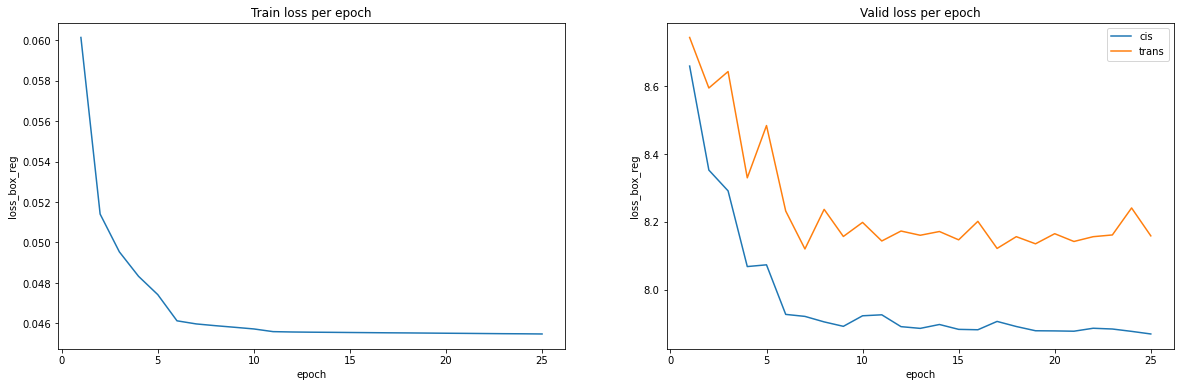

In [35]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss, label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()


#### Save the figure to pdf format in the figures folder

In [36]:
fig.savefig("figures/" + time.strftime("%Y%m%d_%H%M%S") + "_figure.pdf")

## Make Predictions with a model

### OPTIONAL - Can load a model right here to test the predictions quickly
#### Need to initiate the model, the optimizer and de scheduler before loading

In [ ]:
# NEED TO INITIATE THE MODEL, THE OPTIMIZER AND THE SCHEDULER BEFOREHAND (if )
# load the model, the optimizer and the scheduler
model.load_state_dict(torch.load('saved_models/25_roi_model.pt'))
optimizer.load_state_dict(torch.load('saved_models/25_roi_optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_models/25_roi_scheduler.pt'))
model.eval()

### Predictions

In [44]:
train_features, train_labels = next(iter(trans_valid_dataloader))
image = list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
      pred = model(image)

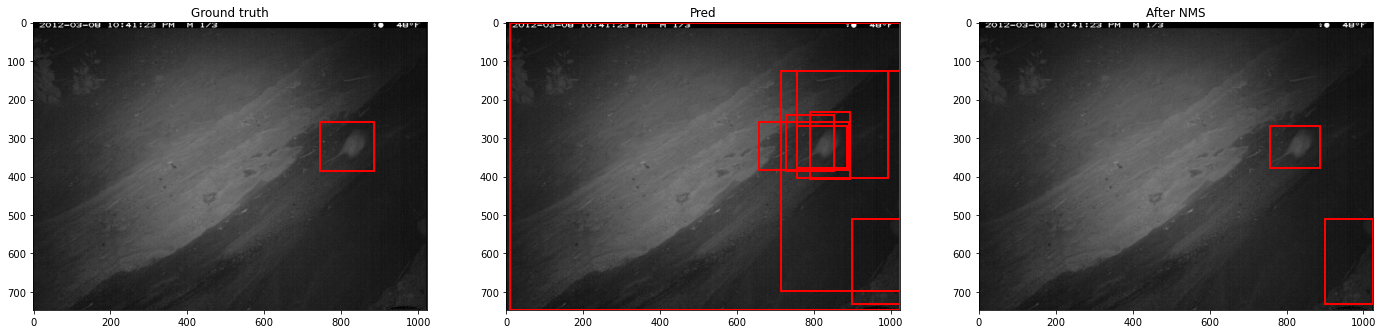

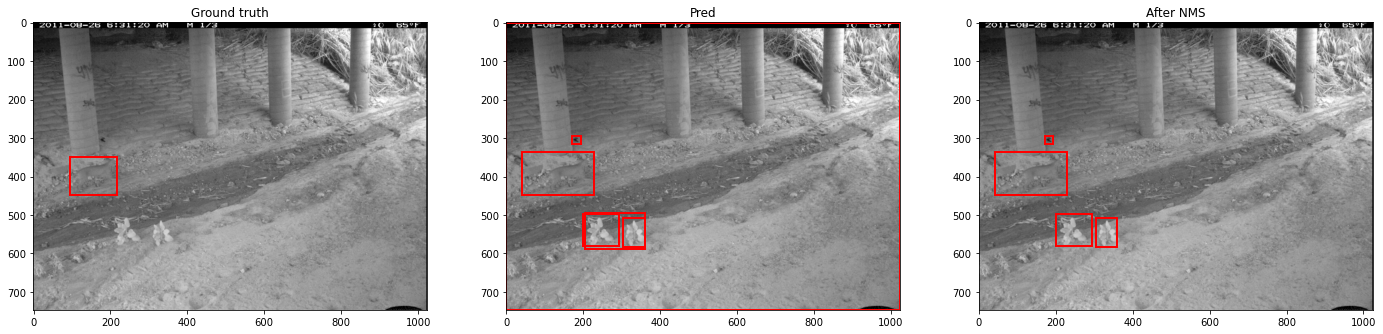

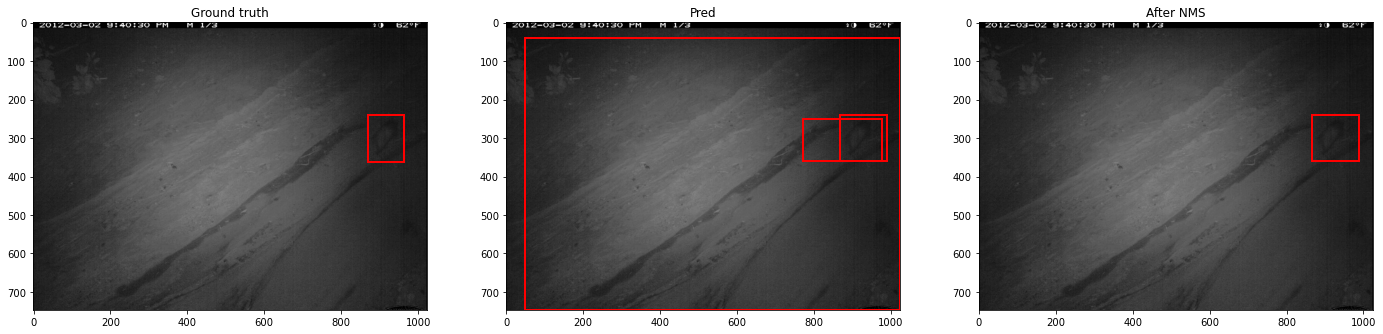

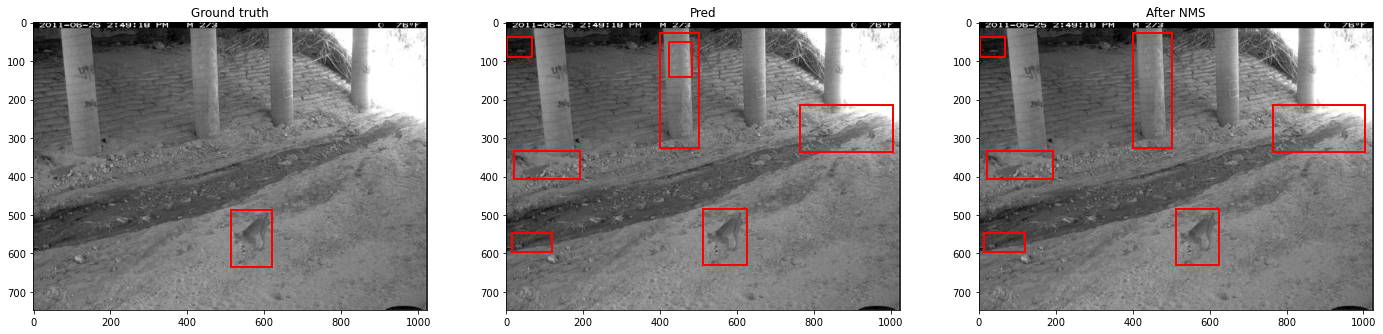

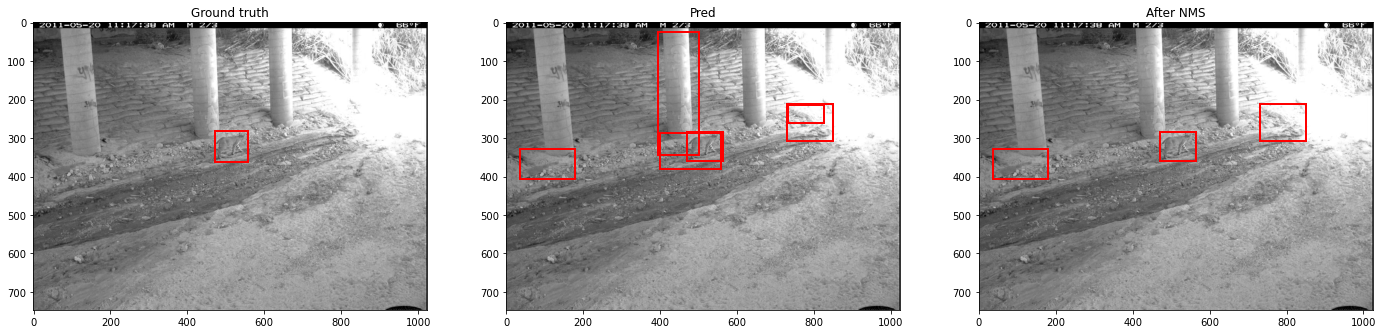

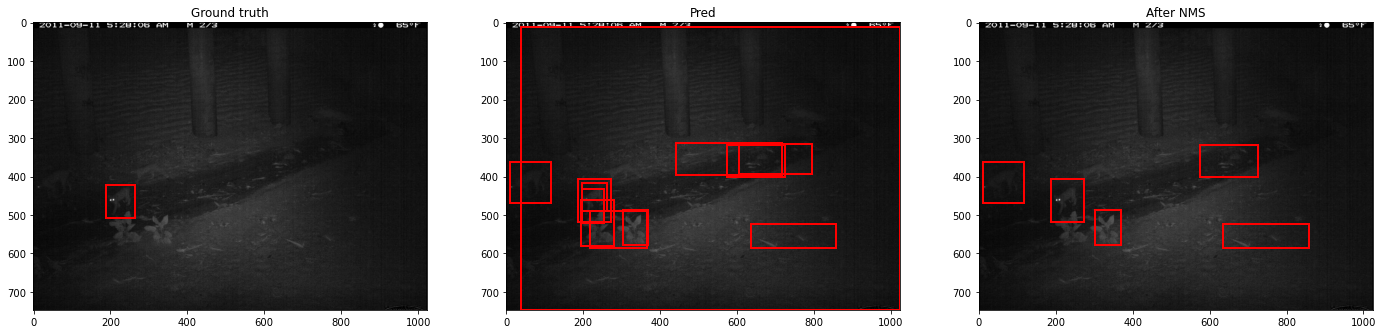

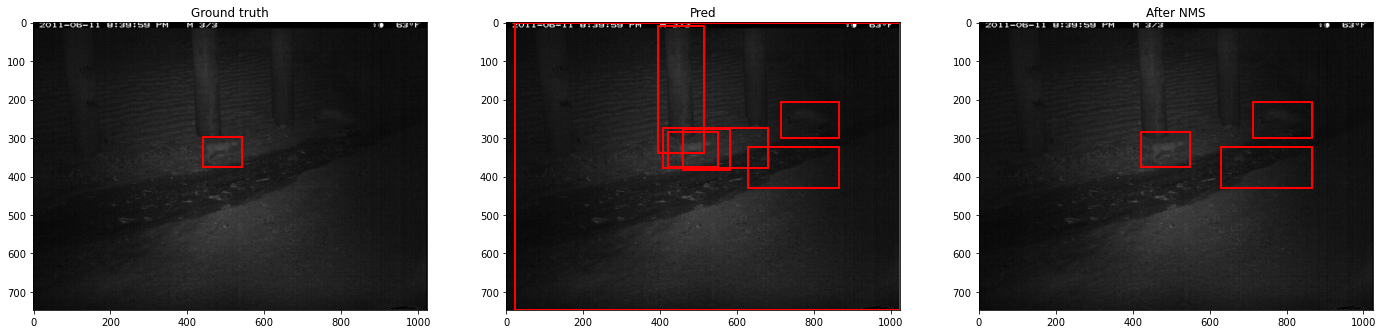

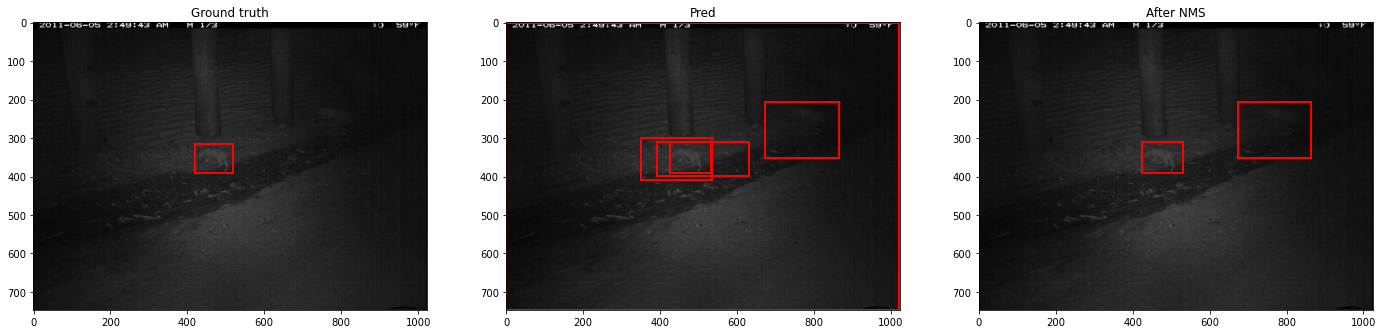

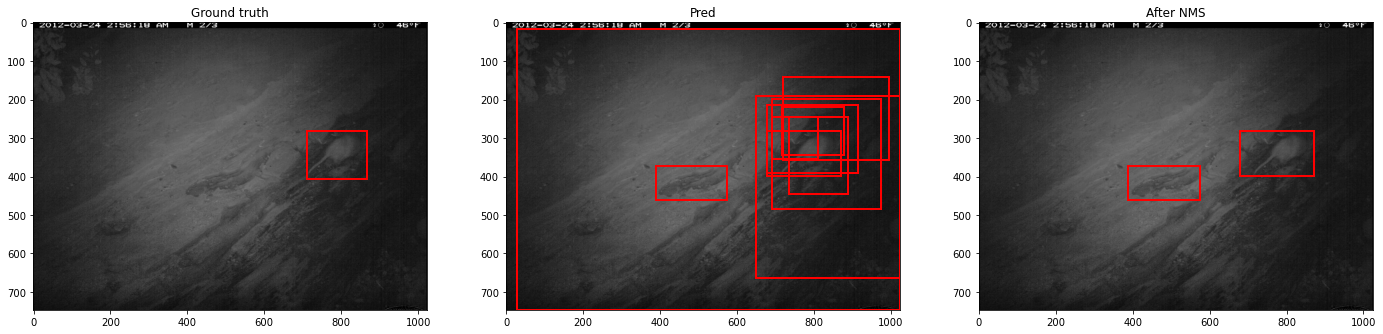

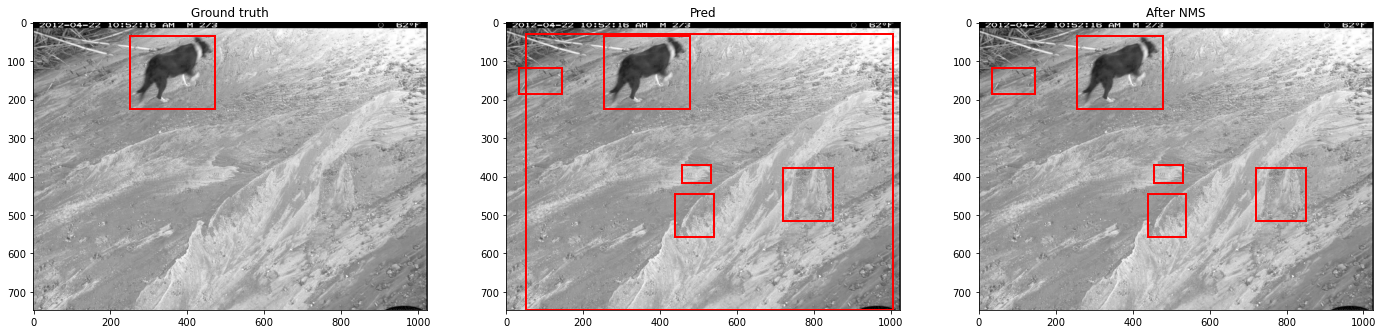

In [45]:
# Prints 10 images with the predictions before and after NMS
for image_i in range(len(image)):
    fig, ax = plt.subplots(1,3,figsize=(24,16))

    ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    rect = patches.Rectangle((train_labels[image_i]['boxes'][0][0], 
                              train_labels[image_i]['boxes'][0][1]), 
                             train_labels[image_i]['boxes'][0][2]-train_labels[image_i]['boxes'][0][0], 
                             train_labels[image_i]['boxes'][0][3]-train_labels[image_i]['boxes'][0][1], 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Ground truth')

    # Predictions
    ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in range(len(pred[image_i]['boxes'])):
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
    ax[1].set_title('Pred')

    # Predictions after NMS
    iou_threshold = 0.01 # param to tune
    boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
    ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in boxes_to_keep:
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[2].add_patch(rect)

    ax[2].set_title('After NMS')

In [46]:
trans_val_ann['images'][train_labels[3]['image_id']]

{'file_name': '588f6901-23d2-11e8-a6a3-ec086b02610b.jpg',
 'rights_holder': 'Justin Brown',
 'height': 1494,
 'width': 2048,
 'frame_num': 2,
 'date_captured': '2011-06-25 14:49:18',
 'location': 125,
 'seq_num_frames': 3,
 'seq_id': '6f15c8ca-5567-11e8-89bf-dca9047ef277',
 'id': '588f6901-23d2-11e8-a6a3-ec086b02610b'}

Text(0.5, 1.0, 'After NMS')

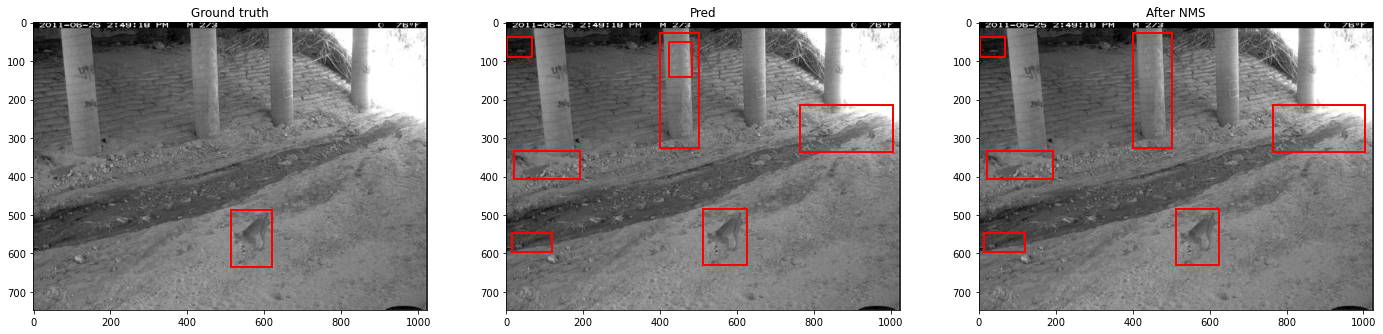

In [49]:
# Print a single image chosen by index from the last batch of 10 predictions
image_i = 3 # from 0 to 9 included

fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(train_labels[image_i]['boxes'])):
    rect = patches.Rectangle((train_labels[image_i]['boxes'][i][0], 
                            train_labels[image_i]['boxes'][i][1]), 
                            train_labels[image_i]['boxes'][i][2]-train_labels[image_i]['boxes'][i][0], 
                            train_labels[image_i]['boxes'][i][3]-train_labels[image_i]['boxes'][i][1], 
                            linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

# Predictions
ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(pred[image_i]['boxes'])):
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Pred')

# Predictions after NMS
iou_threshold = 0.01 # param to tune
boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[2].set_title('After NMS')

In [50]:
boxes_to_keep

tensor([0, 1, 2, 3, 5, 6])

In [51]:
pred[image_i]['boxes'][0]

tensor([511.5512, 484.2361, 625.5700, 630.4005], device='cuda:0')

In [52]:
train_labels[image_i]['boxes']

tensor([[513., 487., 621., 634.]])

## Evalutate on COCO detection metrics

### Cis Test on COCO metrics
##### 'For evaluation, we consider a detected box to be correct if its IoU ≥ 0.5 with a ground truth box.'

We need to look at the precison score with IoU=0.5, area=all and maxDets=100.
For the recall score, by default it's IoU=0.5:IoU=0.95.

In [37]:
# Evaluate perfo on COCO detection metrics

# takes +- 25min to run on cis_test

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

apply_nms = True
iou_threshold = 0.35 # param to potentially tune
the_data_loader = cis_test_dataloader # change to test set

coco = get_coco_api_from_dataset(the_data_loader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

model.eval()

for images, targets in the_data_loader:
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():

        pred=model(images)

        if apply_nms:
            boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold=iou_threshold).cpu()
            pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
            pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
            pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

        outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
print('_'*20)
print('Cis Test Data - Summary')
print(" ")
coco_evaluator.summarize()

creating index...
index created!
Accumulating evaluation results...
DONE (t=1.78s).
____________________
Cis Test Data - Summary
 
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.836
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.569
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=med

### Trans Test on COCO metrics

In [ ]:
# for param in model.roi_heads.box_predictor.cls_score[0].parameters():
#     print(param)

In [ ]:
# model.roi_heads.box_predictor.cls_score[0].weight = nn.Parameter(X_target_proj.float(), requires_grad = False) 
# model.roi_heads.box_predictor.bbox_pred[0].weight = nn.Parameter(X_target_proj.float(), requires_grad = False)
# model.to(device)

In [38]:
# Evaluate perfo on COCO detection metrics

# takes +- 25min to run on trans_test

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

apply_nms = True
iou_threshold = 0.35 # param to potentially tune
the_data_loader = trans_test_dataloader # change to test set

coco = get_coco_api_from_dataset(the_data_loader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

model.eval()

for images, targets in the_data_loader:
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():

        pred=model(images)

        if apply_nms:
            boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold=iou_threshold).cpu()
            pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
            pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
            pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

        outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
print('_'*20)
print('Trans Test Data - Summary')
print(" ")
coco_evaluator.summarize()

creating index...
index created!
Accumulating evaluation results...
DONE (t=2.80s).
____________________
Trans Test Data - Summary
 
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.763
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.473
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

# Methods

## Method 3 (Subspace alignment based Domain adaptation)

In [ ]:
import torchvision.ops.boxes as bops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn

Papers 

 1. https://arxiv.org/pdf/1507.05578.pdf

 2.  https://openaccess.thecvf.com/content_iccv_2013/papers/Fernando_Unsupervised_Visual_Domain_2013_ICCV_paper.pdf

**Construct source matrix:** 

We keep output of model.roi_heads.box_head (vector of size 1024) as feature representations of bounding boxes extracted by the RPN (region proposal network). For us to stack a box representation to the source matrix, it has to have a IoU > thres_IoU with the ground truth of the given image. 

In [ ]:
# 20 minutes
thres_IoU = 0.50
count = 0

X_source = torch.tensor([])
bbox_idx = torch.arange(1000)

model.eval()

for images, targets in train_dataloader: 
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    count += 1

    if count%100 == 0:
        print(count)

    with torch.no_grad():
        outputs = []
        hook = model.rpn.register_forward_hook(
        lambda self, input, output: outputs.append(output))

        outputs1 = []
        hook1 = model.roi_heads.box_head.register_forward_hook(
        lambda self, input, output: outputs1.append(output))

        res = model(images)
        hook.remove()
        hook1.remove()

    coords = outputs[0][0][0].cpu() # [1000,4]
    feat = outputs1[0].cpu() # [1000, 1024]

    gt = targets[0]['boxes'].cpu()

    bbox_idx_to_keep = torch.tensor([])
    for i in range(gt.shape[0]):

        IoUs = bops.box_iou(gt[i].reshape(1,4), coords)
        IoUs = IoUs.reshape(1000)
        bbox_idx_to_keep = torch.cat((bbox_idx_to_keep, bbox_idx[IoUs >= thres_IoU]),dim=0)

    X_source = torch.cat((X_source,feat[torch.unique(bbox_idx_to_keep).long()]), dim=0)

In [ ]:
X_source.shape

### Save 1

In [ ]:
torch.save(X_source, 'saved_data/X_source_05_roi_3_augment.pt')

In [ ]:
# center data
scaler = StandardScaler()
X_source_scaled = scaler.fit_transform(X_source)

In [ ]:
# Apply PCA, keep only the first 100 components which gives the Projected source matrix

pca = PCA(n_components=100)
pca.fit(X_source_scaled)

X_source_proj = pca.components_
X_source_proj = torch.from_numpy(X_source_proj)


In [ ]:
X_source_proj.shape

In [ ]:
plt.plot(pca.explained_variance_ratio_) 
plt.grid()

### Save 2

In [ ]:
torch.save(X_source_proj, 'saved_data/X_source_proj_05_roi_3_augment.pt')

### Target data with batch size 1

In [ ]:
# Target data/distribution = trans test set - Batch Size 1
trans_test_batch1_img,_ = get_img_with_bbox(trans_test_ann_path)
trans_test_batch1_data = CustomImageDataset(trans_test_ann_path, img_folder, trans_test_batch1_img)
trans_test_batch1_dataloader = DataLoader(trans_test_batch1_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

 **Construct target matrix:** 
 
We keep output of model.roi_heads.box_head (vector of size 1024) as feature representations of bounding boxes
 extracted by the RPN (region proposal network). For us to stack a box representation to the source matrix, the predicted bbox associated with the feature has to have a confidence score > thres_conf_score (since we don't use target labels we can't use the IoU here).


In [ ]:
# 30 minutes
thres_conf_score= 0.50 
count=0

X_target=torch.tensor([])

model.eval()

for images, targets in trans_test_batch1_dataloader: # trans location valid AND test ?
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    count+=1

    if count%100==0:
        print(count)

    with torch.no_grad():

        outputs = []
        hook = model.backbone.register_forward_hook(
        lambda self, input, output: outputs.append(output))
        res = model(images)
        hook.remove()

        box_features = model.roi_heads.box_roi_pool(outputs[0], [r['boxes'] for r in res], [i.shape[-2:] for i in images])
        box_features = model.roi_heads.box_head(box_features)

    X_target = torch.cat((X_target,box_features[res[0]['scores']>=thres_conf_score].cpu()), dim=0)


In [ ]:
X_target.shape

In [ ]:
torch.save(X_target, 'saved_data/X_target_05_roi_3_augment.pt')

In [ ]:
# center data
scaler = StandardScaler()
X_target_scaled = scaler.fit_transform(X_target)

In [ ]:
# Apply PCA, keep only the first 100 components which gives the Projected source matrix

pca_proj = PCA(n_components=100)
pca_proj.fit(X_target_scaled)

X_target_proj = pca_proj.components_
X_target_proj = torch.from_numpy(X_target_proj)

In [ ]:
plt.plot(pca_proj.explained_variance_ratio_) # we keep 100 dimensions
plt.grid()

In [ ]:
X_target_proj.shape

In [ ]:
torch.save(X_target_proj, 'saved_data/X_target_proj_05_roi_3_augment.pt')

### Transformation matrix M

𝑀 is obtained by minimizing the following Bregman matrix divergence (following closed-form solution given in the paper)

In [ ]:
M = torch.matmul(X_source_proj, X_target_proj.T) 

In [ ]:
M.shape

### Project source data into target aligned source subspace

In [ ]:
Xa = torch.matmul(X_source_proj.T,M)

In [ ]:
Xa.shape

In [ ]:
# To project a given feature

# feat(1,1024) x Xa (1024,100)

### Projet target data in target subspace

In [ ]:
# To project a given feature

# feat(1,1024) x X_target_proj.T (1024,100)

### Train adapted model

In [ ]:
import torchvision.ops.boxes as bops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [ ]:
# Load because it takes time to generate the following matrices so they are saved
X_source_proj = torch.load('saved_data/X_source_proj_05_roi_3_augment.pt')
X_target_proj = torch.load('saved_data/X_target_proj_05_roi_3_augment.pt')

In [ ]:
X_source_proj.device

In [ ]:
M = torch.matmul(X_source_proj, X_target_proj.T) # transformation matrix
print(M.shape)

Xa = torch.matmul(X_source_proj.T,M) # target aligned source subspace
print(Xa.shape)

In [ ]:
M.to(device)

In [ ]:
Xa.to(device)

In [ ]:
class FastRCNNPredictor_custom(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes, m_transfo):
        super(FastRCNNPredictor_custom, self).__init__()
        self.cls_score = nn.Sequential(nn.Linear(in_features = 1024, out_features = 100, bias=False), nn.Linear(in_channels, num_classes))
        self.bbox_pred = nn.Sequential(nn.Linear(in_features = 1024, out_features = 100, bias=False), nn.Linear(in_channels, num_classes * 4))
        self.cls_score[0].weight= nn.Parameter(m_transfo, requires_grad = False)
        self.bbox_pred[0].weight= nn.Parameter(m_transfo, requires_grad = False)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# load fine-tuned weights
model.load_state_dict(torch.load('saved_models/25_roi_3_augment_model.pt'))


for param in model.parameters(): # to freeze all existing weights

    param.requires_grad = False

# vector are of size 100 after the transformation
model.roi_heads.box_predictor = FastRCNNPredictor_custom(in_channels=100, num_classes=2, m_transfo=Xa.T.float()) 

# move model to the right device
model.to(device)

# construct an optimizer
# We will only retrain model.roi_heads.box_predictor (2 last layers)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [ ]:
# weights to learn
for i in range(4):
    print(params[i].shape)

In [ ]:
# Nb of weights in the optimizer
for i in range(len(optimizer.param_groups[0]['params'])):
    print(optimizer.param_groups[0]['params'][i].shape)

In [ ]:
# TRAIN

all_train_logs=[]
all_trans_valid_logs=[]
all_cis_valid_logs=[]

num_epochs = 25

for epoch in range(num_epochs):
    
    # train for one epoch, printing every 100 images
    train_logs = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=100)
    all_train_logs.append(train_logs)
    
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset

    for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            trans_loss_dict = model(images, targets)
            trans_loss_dict= [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
            all_trans_valid_logs.append(trans_loss_dict)


    for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            cis_loss_dict = model(images, targets)
            cis_loss_dict= [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
            all_cis_valid_logs.append(cis_loss_dict)


In [ ]:
model

In [ ]:
torch.version.cuda

In [ ]:
torch.version.git_version

In [ ]:
torchvision.version.git_version